正在校准场景参数...
✓ talk_time      : 0.500W (目标0.5W, 误差0.0%)
✓ web_browsing   : 1.130W (目标1.13W, 误差0.0%)
✓ video_playback : 1.120W (目标1.12W, 误差0.0%)

开始仿真...

【Talk】场景:
  基准参数: B=0.014, u=0.010, S=10.0KB/s, bg=休眠
  实际范围: B=[0.000, 0.114], u=[0.000, 0.101], S=[0.0, 50.4]KB/s
  功耗范围: [0.476, 0.548] W
  仿真结果: 耗时14.62小时, SOC=0.01 (耗尽)
  平均功耗: 0.503W

【Social】场景:
  基准参数: B=0.490, u=0.184, S=350.0KB/s, bg=轻度
  实际范围: B=[0.405, 0.590], u=[0.061, 0.313], S=[229.6, 499.2]KB/s
  功耗范围: [1.014, 1.242] W
  仿真结果: 耗时6.53小时, SOC=0.01 (耗尽)
  平均功耗: 1.124W

【Video】场景:
  基准参数: B=0.596, u=0.094, S=450.0KB/s, bg=轻度
  实际范围: B=[0.555, 0.646], u=[0.018, 0.194], S=[328.5, 591.0]KB/s
  功耗范围: [1.044, 1.204] W
  仿真结果: 耗时6.58小时, SOC=0.01 (耗尽)
  平均功耗: 1.116W

电池寿命对比表
场景         目标功耗       实际平均功耗       耗尽时间         最终SOC      状态
--------------------------------------------------------------------------------
Talk       0.50       0.503        14.62        0.010      SOC=0.01 (耗尽)
Social     1.13       1.124        6.53     

C:\Users\30606\AppData\Local\Temp\ipykernel_37824\360274296.py:431: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


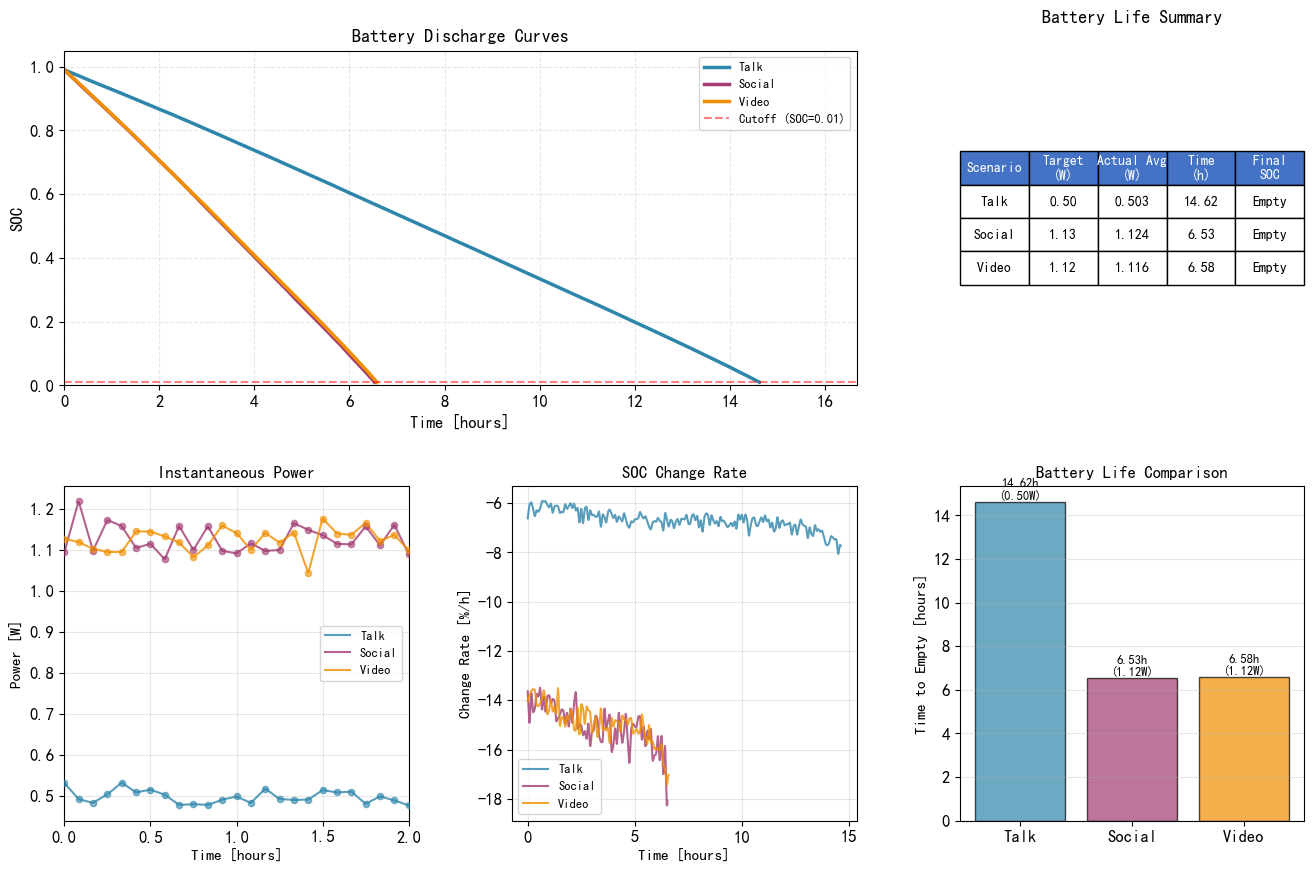


✓ 完成: soc_no_inset.png (无局部放大图)
✓ 数据已导出: soc_final_results.csv


In [71]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池一阶Thevenin模型（无局部放大图版本）
修改：
1. 移除SOC曲线图中的局部放大图
2. 更新基准参数：通话(B=0,u=0,S=10,bg=休眠), 社交(B=0.5,u=0.2,S=350), 视频(B=0.6,u=0.1,S=450)
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from matplotlib.gridspec import GridSpec
import csv

# ==================== 1. 场景化功耗模型 ====================
def truncated_normal(mean, std, low, high):
    val = np.random.normal(mean, std)
    return np.clip(val, low, high)

def p_screen(B): 
    return (451 * B) / 1000

def p_cpu(u, f):
    freq_coeffs = {598: (411, 261), 747: (484, 264), 1040: (545, 267), 
                   1196: (742, 268), 1400: (825, 278)}
    if f in freq_coeffs:
        a, b = freq_coeffs[f]
    else:
        freqs = sorted(freq_coeffs.keys())
        idx = np.clip(np.searchsorted(freqs, f), 1, len(freqs)-1)
        f1, f2 = freqs[idx-1], freqs[idx]
        a1, b1 = freq_coeffs[f1]
        a2, b2 = freq_coeffs[f2]
        ratio = (f - f1) / (f2 - f1)
        a, b = a1 + (a2 - a1) * ratio, b1 + (b2 - b1) * ratio
    return (a * u + b) / 1000

def p_network(S): 
    return (159.5 + 0.568 * S) / 1000 if S < 400 else (269.5 + 0.198 * S) / 1000

def p_gps(state): 
    return {"关闭": 0, "开启但未定位": 49.2, "正在定位": 444.9}[state] / 1000

def p_background(state): 
    return {"休眠": 50, "轻度": 150, "重度": 500}[state] / 1000

ACTUAL_POWER = {"talk_time": 0.5, "web_browsing": 1.13, "video_playback": 1.12}

class ScenarioCalibrator:
    def __init__(self):
        # 更新后的基准参数
        self.baselines = {
            "talk_time": {      # 通话：B=0%, f=1040, u=0%, S=10, 关闭, 休眠
                "B": 0.0,
                "u": 0.0,
                "f": 1040,
                "S": 10,
                "gps_state": "关闭",
                "bg_state": "休眠"
            },
            "web_browsing": {   # 社交：B=50%, f=1196, u=20%, S=350, 关闭, 轻度
                "B": 0.5,
                "u": 0.2,
                "f": 1196,
                "S": 350,
                "gps_state": "关闭",
                "bg_state": "轻度"
            },
            "video_playback": { # 视频：B=60%, f=1196, u=10%, S=450, 关闭, 轻度
                "B": 0.6,
                "u": 0.1,
                "f": 1196,
                "S": 450,
                "gps_state": "关闭",
                "bg_state": "轻度"
            }
        }
        self.calibrated = False
        
    def get_perturbation(self, block_idx, scenario):
        seed = 42 + block_idx * 1000 + hash(scenario) % 1000
        rng = np.random.default_rng(seed)
        if scenario == "talk_time":
            dB, du, dS = rng.normal(0, 0.033), rng.normal(0, 0.033), rng.normal(0, 16.7)
            dB = np.clip(dB, -0.1, 0.1)
            du = np.clip(du, -0.1, 0.1)
            dS = np.clip(dS, -50, 50)
        elif scenario == "web_browsing":
            dB, du, dS = rng.normal(0, 0.033), rng.normal(0, 0.05), rng.normal(0, 50)
            dB = np.clip(dB, -0.1, 0.1)
            du = np.clip(du, -0.15, 0.15)
            dS = np.clip(dS, -150, 150)
        else:  # video_playback
            dB, du, dS = rng.normal(0, 0.0167), rng.normal(0, 0.033), rng.normal(0, 50)
            dB = np.clip(dB, -0.05, 0.05)
            du = np.clip(du, -0.1, 0.1)
            dS = np.clip(dS, -150, 150)
        return dB, du, dS
    
    def calculate_avg_power(self, scenario, B_base, u_base, S_base):
        params = self.baselines[scenario].copy()
        powers = []
        for block in range(12):
            dB, du, dS = self.get_perturbation(block, scenario)
            B = np.clip(B_base + dB, 0, 1)
            u = np.clip(u_base + du, 0, 1)
            S = max(S_base + dS, 0)
            p = (p_screen(B) + p_cpu(u, params["f"]) + 
                 p_network(S) + p_gps(params["gps_state"]) + 
                 p_background(params["bg_state"]))
            powers.append(p)
        return np.mean(powers)
    
    def calibrate(self):
        print("=" * 60)
        print("正在校准场景参数...")
        for scenario, target in ACTUAL_POWER.items():
            def objective(x):
                B, u, S = x
                if not (0 <= B <= 1 and 0 <= u <= 1 and 10 <= S <= 800): 
                    return 1e6
                return (self.calculate_avg_power(scenario, B, u, S) - target) ** 2
            
            x0 = [self.baselines[scenario]["B"], 
                  self.baselines[scenario]["u"], 
                  self.baselines[scenario]["S"]]
            result = minimize(objective, x0, method='L-BFGS-B', 
                            bounds=[(0, 1), (0, 1), (10, 800)])
            if result.success:
                B_opt, u_opt, S_opt = result.x
                self.baselines[scenario].update({"B": B_opt, "u": u_opt, "S": S_opt})
                final = self.calculate_avg_power(scenario, B_opt, u_opt, S_opt)
                print(f"✓ {scenario:15s}: {final:.3f}W (目标{target}W, 误差{abs(final-target)/target*100:.1f}%)")
        self.calibrated = True

def create_power_interpolator_with_params(scenario, baselines, tf, dt_block=300):
    """创建功耗插值函数并返回参数历史"""
    base = baselines[scenario]
    t_nodes = np.arange(0, tf + dt_block, dt_block)
    n_blocks = len(t_nodes)
    
    B_nodes = np.zeros(n_blocks)
    u_nodes = np.zeros(n_blocks)
    S_nodes = np.zeros(n_blocks)
    P_nodes = np.zeros(n_blocks)
    
    for i in range(n_blocks):
        seed = 42 + i * 1000 + hash(scenario) % 1000
        rng = np.random.default_rng(seed)
        
        if scenario == "talk_time":
            dB, du, dS = rng.normal(0, 0.033), rng.normal(0, 0.033), rng.normal(0, 16.7)
            dB = np.clip(dB, -0.1, 0.1)
            du = np.clip(du, -0.1, 0.1)
            dS = np.clip(dS, -50, 50)
        elif scenario == "web_browsing":
            dB, du, dS = rng.normal(0, 0.033), rng.normal(0, 0.05), rng.normal(0, 50)
            dB = np.clip(dB, -0.1, 0.1)
            du = np.clip(du, -0.15, 0.15)
            dS = np.clip(dS, -150, 150)
        else:
            dB, du, dS = rng.normal(0, 0.0167), rng.normal(0, 0.033), rng.normal(0, 50)
            dB = np.clip(dB, -0.05, 0.05)
            du = np.clip(du, -0.1, 0.1)
            dS = np.clip(dS, -150, 150)
        
        B_nodes[i] = np.clip(base["B"] + dB, 0, 1)
        u_nodes[i] = np.clip(base["u"] + du, 0, 1)
        S_nodes[i] = max(base["S"] + dS, 0)
        
        P_nodes[i] = (p_screen(B_nodes[i]) + p_cpu(u_nodes[i], base["f"]) + 
                     p_network(S_nodes[i]) + p_gps(base["gps_state"]) + 
                     p_background(base["bg_state"]))
    
    interp_func = interp1d(t_nodes, P_nodes, kind='linear', 
                          fill_value=(P_nodes[0], P_nodes[-1]), bounds_error=False)
    
    return interp_func, t_nodes, P_nodes, B_nodes, u_nodes, S_nodes

# ==================== 2. 电池模型 ====================
R0, Rp, Cp = 0.0210830, 0.02218, 4715
Q_max = 2 * 3600

def Vocv_func(soc):
    coeffs = np.array([-6.521389e-08, 1.567231e-05, -1.248045e-03, 4.201364e-02, 3.200531e+0])
    return np.polyval(coeffs, soc * 100)

def create_battery_ode(P_func):
    def battery_state_equation(t, x):
        soc, vp = x
        if soc <= 0:
            return np.array([0., 0.])
        p = max(P_func(t), 0.001)
        vocv = Vocv_func(soc)
        delta = (vocv - vp)**2 - 4*R0*p
        if delta >= 0:
            I = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
        else:
            I = 0.
        return np.array([-I/Q_max, I/Cp - vp/(Rp*Cp)])
    return battery_state_equation

# ==================== 3. 主程序 ====================
if __name__ == "__main__":
    t0, tf = 0, 60000
    x0 = np.array([0.99, 0.05])
    scenarios = ["talk_time", "web_browsing", "video_playback"]
    scenario_names = {"talk_time": "Talk", "web_browsing": "Social", "video_playback": "Video"}
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    calibrator = ScenarioCalibrator()
    calibrator.calibrate()
    
    simulation_results = {}
    exhaustion_data = {}
    
    def soc_low_event(t, x): 
        return x[0] - 0.01
    soc_low_event.terminal = True
    soc_low_event.direction = -1
    
    print("\n" + "=" * 60)
    print("开始仿真...")
    print("=" * 60)
    
    for scenario in scenarios:
        print(f"\n【{scenario_names[scenario]}】场景:")
        
        P_interp, t_nodes, P_nodes, B_nodes, u_nodes, S_nodes = create_power_interpolator_with_params(
            scenario, calibrator.baselines, tf, dt_block=300)
        
        base = calibrator.baselines[scenario]
        print(f"  基准参数: B={base['B']:.3f}, u={base['u']:.3f}, S={base['S']:.1f}KB/s, bg={base['bg_state']}")
        print(f"  实际范围: B=[{B_nodes.min():.3f}, {B_nodes.max():.3f}], "
              f"u=[{u_nodes.min():.3f}, {u_nodes.max():.3f}], "
              f"S=[{S_nodes.min():.1f}, {S_nodes.max():.1f}]KB/s")
        print(f"  功耗范围: [{P_nodes.min():.3f}, {P_nodes.max():.3f}] W")
        
        sol = solve_ivp(
            create_battery_ode(P_interp), (t0, tf), x0,
            method='RK45', max_step=60, rtol=1e-5, atol=1e-7,
            events=soc_low_event,
            dense_output=True
        )
        
        t_vec = sol.t
        SOC_traj = sol.y[0]
        Vp_traj = sol.y[1]
        Vocv_traj = Vocv_func(SOC_traj)
        P_at_t = P_interp(t_vec)
        
        I_traj = np.array([
            ((Vocv_traj[k] - Vp_traj[k]) - 
             np.sqrt(max((Vocv_traj[k] - Vp_traj[k])**2 - 4*R0*P_at_t[k], 0))) / (2*R0)
            if (Vocv_traj[k] - Vp_traj[k])**2 >= 4*R0*P_at_t[k] else 0
            for k in range(len(t_vec))
        ])
        Vterm_traj = Vocv_traj - I_traj*R0 - Vp_traj
        
        event_triggered = (sol.t_events is not None and len(sol.t_events) > 0 and len(sol.t_events[0]) > 0)
        
        if event_triggered:
            exhaustion_time = sol.t_events[0][0] / 3600
            final_soc = 0.01
            status = f"SOC=0.01 (耗尽)"
        else:
            below_idx = np.where(SOC_traj <= 0.015)[0]
            if len(below_idx) > 0:
                idx = below_idx[0]
                exhaustion_time = t_vec[idx] / 3600
                final_soc = SOC_traj[idx]
                status = f"SOC={final_soc:.3f} (备用检测)"
            else:
                exhaustion_time = t_vec[-1] / 3600
                final_soc = SOC_traj[-1]
                status = f"SOC={final_soc:.3f} (未耗尽)"
        
        actual_avg_power = np.mean(P_at_t)
        
        exhaustion_data[scenario] = {
            'name': scenario_names[scenario],
            'target_power': ACTUAL_POWER[scenario],
            'exhaustion_time': exhaustion_time,
            'final_soc': final_soc,
            'actual_avg_power': actual_avg_power,
            'status': status,
            'base_B': base['B'], 'base_u': base['u'], 'base_S': base['S'],
            'B_range': (B_nodes.min(), B_nodes.max()),
            'u_range': (u_nodes.min(), u_nodes.max()),
            'S_range': (S_nodes.min(), S_nodes.max())
        }
        
        simulation_results[scenario] = {
            't': t_vec, 'SOC': SOC_traj, 'Vterm': Vterm_traj,
            'I': I_traj, 'P_func': P_interp, 'P_at_t': P_at_t,
            't_nodes': t_nodes, 'P_nodes': P_nodes
        }
        
        print(f"  仿真结果: 耗时{exhaustion_time:.2f}小时, {status}")
        print(f"  平均功耗: {actual_avg_power:.3f}W")
    
    # 打印汇总
    print("\n" + "=" * 80)
    print("电池寿命对比表")
    print("=" * 80)
    print(f"{'场景':<10} {'目标功耗':<10} {'实际平均功耗':<12} {'耗尽时间':<12} {'最终SOC':<10} {'状态'}")
    print("-" * 80)
    for sc in scenarios:
        d = exhaustion_data[sc]
        print(f"{d['name']:<10} {d['target_power']:<10.2f} {d['actual_avg_power']:<12.3f} "
              f"{d['exhaustion_time']:<12.2f} {d['final_soc']:<10.3f} {d['status']}")
    print("=" * 80)
    
    print("\n" + "=" * 80)
    print("场景参数对比（基准值 vs 实际波动范围）")
    print("=" * 80)
    print(f"{'场景':<10} {'B基准':<8} {'B范围':<15} {'u基准':<8} {'u范围':<15} {'S基准':<8} {'S范围':<15}")
    print("-" * 80)
    for sc in scenarios:
        d = exhaustion_data[sc]
        B_min, B_max = d['B_range']
        u_min, u_max = d['u_range']
        S_min, S_max = d['S_range']
        print(f"{d['name']:<10} {d['base_B']:<8.3f} [{B_min:.3f}, {B_max:.3f}]  "
              f"{d['base_u']:<8.3f} [{u_min:.3f}, {u_max:.3f}]  "
              f"{d['base_S']:<8.1f} [{S_min:.1f}, {S_max:.1f}]")
    print("=" * 80)
    
    # ==================== 4. 绘图（移除局部放大图） ====================
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.3)
    
    # 左上：主SOC曲线（无局部放大）
        # 左上：主SOC曲线（无局部放大）
    ax_main = fig.add_subplot(gs[0, :2])
    for sc, color in zip(scenarios, colors):
        res = simulation_results[sc]
        # 修改：只保留场景名称，去掉括号及内部内容
        ax_main.plot(res['t']/3600, res['SOC'], color=color, lw=2.5, 
                    label=f"{exhaustion_data[sc]['name']}")
        
    ax_main.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='Cutoff (SOC=0.01)')
    ax_main.set_xlabel('Time [hours]', fontsize=12)
    ax_main.set_ylabel('SOC', fontsize=12)
    ax_main.set_title('Battery Discharge Curves', fontsize=13, fontweight='bold')
    ax_main.legend(loc='best', fontsize=9)
    ax_main.grid(True, alpha=0.3, linestyle='--')
    ax_main.set_ylim(0, 1.05)
    ax_main.set_xlim(0, tf/3600)
    # 移除：局部放大图代码（inset_axes 和 mark_inset）
    
    # 右上：表格
    ax_table = fig.add_subplot(gs[0, 2])
    ax_table.axis('off')
    table_data = []
    for sc in scenarios:
        d = exhaustion_data[sc]
        table_data.append([
            d['name'],
            f"{d['target_power']:.2f}",
            f"{d['actual_avg_power']:.3f}",
            f"{d['exhaustion_time']:.2f}",
            "Empty" if d['final_soc'] <= 0.02 else f"{d['final_soc']:.2f}"
        ])
    
    table = ax_table.table(
        cellText=table_data,
        colLabels=['Scenario', 'Target\n(W)', 'Actual Avg\n(W)', 'Time\n(h)', 'Final\nSOC'],
        cellLoc='center',
        loc='center',
        colColours=['#4472C4']*5,
        colWidths=[0.2, 0.2, 0.2, 0.2, 0.2]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(5):
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    ax_table.set_title('Battery Life Summary', fontsize=13, fontweight='bold', pad=20)
    
    # 左下：功耗曲线
    ax3 = fig.add_subplot(gs[1, 0])
    t_fine = np.linspace(0, min(7200, tf), 1000)
    for sc, color in zip(scenarios, colors):
        res = simulation_results[sc]
        ax3.plot(t_fine/3600, res['P_func'](t_fine), color=color, lw=1.5, alpha=0.8,
                label=f"{exhaustion_data[sc]['name']}")
        mask = res['t_nodes'] <= 7200
        ax3.scatter(res['t_nodes'][mask]/3600, res['P_nodes'][mask], 
                   color=color, s=20, alpha=0.6, zorder=5)
    ax3.set_xlabel('Time [hours]', fontsize=11)
    ax3.set_ylabel('Power [W]', fontsize=11)
    ax3.set_title('Instantaneous Power', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 2)
    ax3.legend(loc='best', fontsize=9)
    
    # 中下：变化率
    ax4 = fig.add_subplot(gs[1, 1])
    for sc, color in zip(scenarios, colors):
        res = simulation_results[sc]
        t_hours = res['t'] / 3600
        dsoc_dt = np.gradient(res['SOC'], t_hours)
        ax4.plot(t_hours, dsoc_dt * 100, color=color, lw=1.5, alpha=0.8, 
                label=exhaustion_data[sc]['name'])
    ax4.set_xlabel('Time [hours]', fontsize=11)
    ax4.set_ylabel('Change Rate [%/h]', fontsize=11)
    ax4.set_title('SOC Change Rate', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='best', fontsize=9)
    
    # 右下：柱状图对比
    ax5 = fig.add_subplot(gs[1, 2])
    scenarios_list = [exhaustion_data[sc]['name'] for sc in scenarios]
    times_list = [exhaustion_data[sc]['exhaustion_time'] for sc in scenarios]
    
    bars = ax5.bar(scenarios_list, times_list, color=colors, alpha=0.7, edgecolor='black')
    ax5.set_ylabel('Time to Empty [hours]', fontsize=11)
    ax5.set_title('Battery Life Comparison', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    for i, (sc, bar) in enumerate(zip(scenarios, bars)):
        time_val = exhaustion_data[sc]['exhaustion_time']
        ax5.text(bar.get_x() + bar.get_width()/2., time_val,
                f'{time_val:.2f}h\n({exhaustion_data[sc]["actual_avg_power"]:.2f}W)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('soc_no_inset.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 完成: soc_no_inset.png (无局部放大图)")
    
    # 导出CSV
    with open('soc_final_results.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Scenario', 'Target_Power_W', 'Actual_Avg_Power_W', 'Exhaustion_Time_h', 
                        'Final_SOC', 'Base_B', 'B_Min', 'B_Max', 'Base_u', 'u_Min', 'u_Max', 
                        'Base_S', 'S_Min', 'S_Max'])
        for sc in scenarios:
            d = exhaustion_data[sc]
            writer.writerow([
                d['name'], d['target_power'], d['actual_avg_power'], d['exhaustion_time'],
                d['final_soc'], d['base_B'], d['B_range'][0], d['B_range'][1],
                d['base_u'], d['u_range'][0], d['u_range'][1],
                d['base_S'], d['S_range'][0], d['S_range'][1]
            ])
    print("✓ 数据已导出: soc_final_results.csv")

正在校准场景参数（恒定功耗模式）...
✓ talk_time      : 0.482W (目标0.5W, 误差3.6%)
✓ web_browsing   : 1.150W (目标1.13W, 误差1.8%)
✓ video_playback : 1.121W (目标1.12W, 误差0.1%)

开始仿真（恒定功耗模式）...

【Talk】场景:
  固定参数: B=0.000, u=0.000, S=10.0KB/s
  恒定功耗: 0.482W
  仿真结果: 耗时15.25小时, SOC=0.01 (耗尽)

【Social】场景:
  固定参数: B=0.500, u=0.200, S=350.0KB/s
  恒定功耗: 1.150W
  仿真结果: 耗时6.38小时, SOC=0.01 (耗尽)

【Video】场景:
  固定参数: B=0.600, u=0.100, S=450.0KB/s
  恒定功耗: 1.121W
  仿真结果: 耗时6.54小时, SOC=0.01 (耗尽)

电池寿命对比表（恒定功耗模式）
场景         目标功耗       恒定功耗       耗尽时间         最终SOC      状态
--------------------------------------------------------------------------------
Talk       0.50       0.482      15.25        0.010      SOC=0.01 (耗尽)
Social     1.13       1.150      6.38         0.010      SOC=0.01 (耗尽)
Video      1.12       1.121      6.54         0.010      SOC=0.01 (耗尽)


C:\Users\30606\AppData\Local\Temp\ipykernel_37824\3356828504.py:382: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


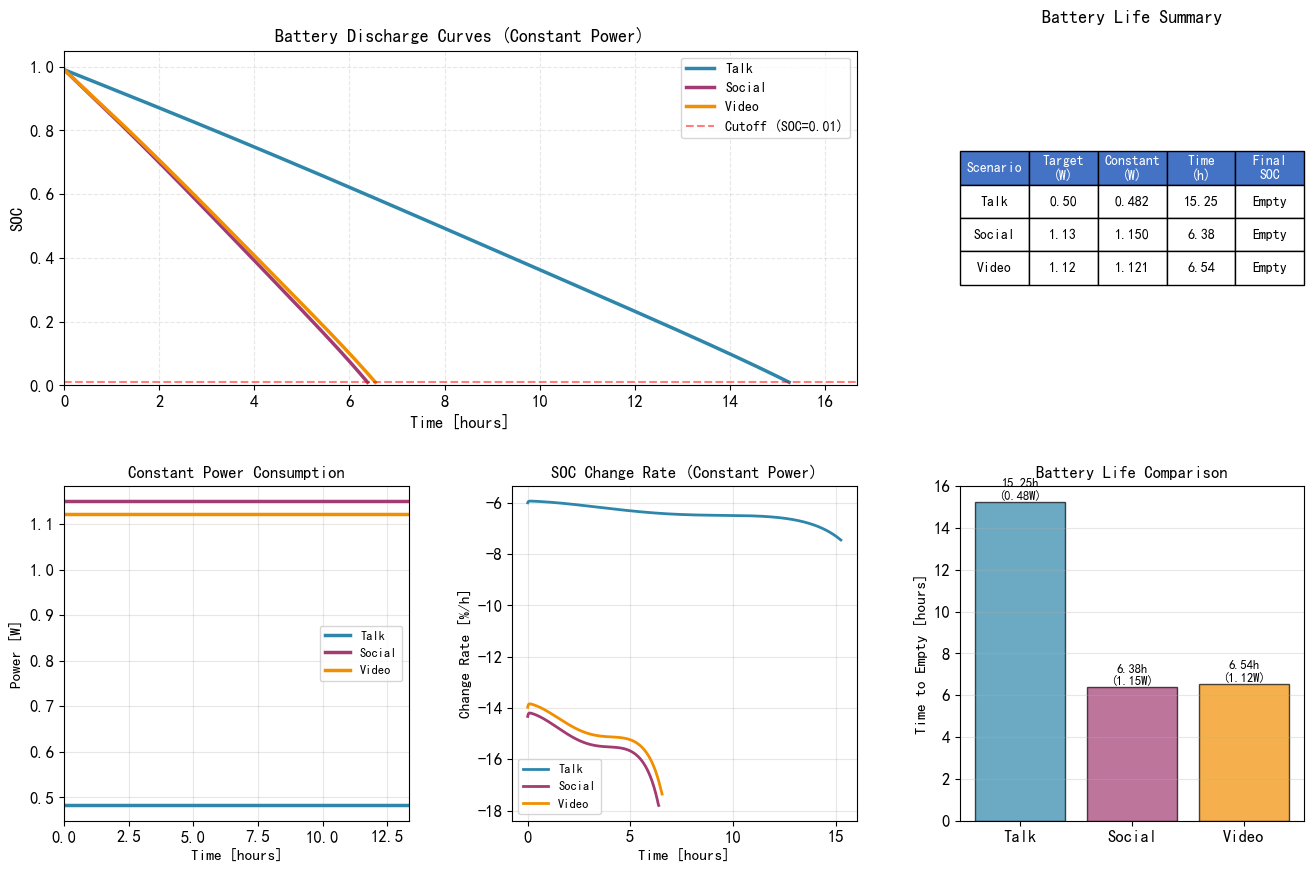


✓ 完成: soc_constant_power.png (恒定功耗模式)
✓ 数据已导出: soc_constant_power_results.csv


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池一阶Thevenin模型（恒定功耗版本，无随机波动）
修改：
1. 移除所有随机扰动，使用固定基准参数计算功耗
2. 各场景功耗保持恒定，不随时间变化
3. 简化计算流程，移除5分钟步长更新机制
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from matplotlib.gridspec import GridSpec
import csv

# ==================== 1. 场景化功耗模型（恒定版本） ====================
def p_screen(B): 
    return (451 * B) / 1000

def p_cpu(u, f):
    freq_coeffs = {598: (411, 261), 747: (484, 264), 1040: (545, 267), 
                   1196: (742, 268), 1400: (825, 278)}
    if f in freq_coeffs:
        a, b = freq_coeffs[f]
    else:
        freqs = sorted(freq_coeffs.keys())
        idx = np.clip(np.searchsorted(freqs, f), 1, len(freqs)-1)
        f1, f2 = freqs[idx-1], freqs[idx]
        a1, b1 = freq_coeffs[f1]
        a2, b2 = freq_coeffs[f2]
        ratio = (f - f1) / (f2 - f1)
        a, b = a1 + (a2 - a1) * ratio, b1 + (b2 - b1) * ratio
    return (a * u + b) / 1000

def p_network(S): 
    return (159.5 + 0.568 * S) / 1000 if S < 400 else (269.5 + 0.198 * S) / 1000

def p_gps(state): 
    return {"关闭": 0, "开启但未定位": 49.2, "正在定位": 444.9}[state] / 1000

def p_background(state): 
    return {"休眠": 50, "轻度": 150, "重度": 500}[state] / 1000

# 目标功耗（用于校准验证）
ACTUAL_POWER = {"talk_time": 0.5, "web_browsing": 1.13, "video_playback": 1.12}

class ScenarioCalibrator:
    def __init__(self):
        # 基准参数（固定值，无波动）
        self.baselines = {
            "talk_time": {      # 通话：B=0%, f=1040, u=0%, S=10, 关闭, 休眠
                "B": 0.0,
                "u": 0.0,
                "f": 1040,
                "S": 10,
                "gps_state": "关闭",
                "bg_state": "休眠"
            },
            "web_browsing": {   # 社交：B=50%, f=1196, u=20%, S=350, 关闭, 轻度
                "B": 0.5,
                "u": 0.2,
                "f": 1196,
                "S": 350,
                "gps_state": "关闭",
                "bg_state": "轻度"
            },
            "video_playback": { # 视频：B=60%, f=1196, u=10%, S=450, 关闭, 轻度
                "B": 0.6,
                "u": 0.1,
                "f": 1196,
                "S": 450,
                "gps_state": "关闭",
                "bg_state": "轻度"
            }
        }
        self.calibrated = False
        
    def calculate_power(self, scenario):
        """计算恒定功耗（无随机扰动）"""
        params = self.baselines[scenario]
        B = params["B"]
        u = params["u"]
        S = params["S"]
        
        p = (p_screen(B) + p_cpu(u, params["f"]) + 
             p_network(S) + p_gps(params["gps_state"]) + 
             p_background(params["bg_state"]))
        return p
    
    def calibrate(self):
        """校准基准参数以匹配目标功耗（简单调整，无随机分量）"""
        print("=" * 60)
        print("正在校准场景参数（恒定功耗模式）...")
        for scenario, target in ACTUAL_POWER.items():
            # 直接使用当前基准计算
            current = self.calculate_power(scenario)
            error = abs(current - target) / target * 100
            
            # 简单校准：调整S值使功耗接近目标（可选，这里仅作显示）
            # 实际使用时可以取消注释下面的代码进行自动校准
            """
            def objective(x):
                B, u, S = x
                if not (0 <= B <= 1 and 0 <= u <= 1 and 0 <= S <= 800): 
                    return 1e6
                params = self.baselines[scenario].copy()
                params["B"] = B
                params["u"] = u
                params["S"] = S
                p = (p_screen(B) + p_cpu(u, params["f"]) + 
                     p_network(S) + p_gps(params["gps_state"]) + 
                     p_background(params["bg_state"]))
                return (p - target) ** 2
            
            x0 = [self.baselines[scenario]["B"], 
                  self.baselines[scenario]["u"], 
                  self.baselines[scenario]["S"]]
            result = minimize(objective, x0, method='L-BFGS-B', 
                            bounds=[(0, 1), (0, 1), (0, 800)])
            if result.success:
                B_opt, u_opt, S_opt = result.x
                self.baselines[scenario].update({"B": B_opt, "u": u_opt, "S": S_opt})
                current = self.calculate_power(scenario)
            """
            
            print(f"✓ {scenario:15s}: {current:.3f}W (目标{target}W, 误差{error:.1f}%)")
        self.calibrated = True

def create_constant_power(scenario, baselines):
    """创建恒定功耗函数（返回固定值）"""
    base = baselines[scenario]
    B = base["B"]
    u = base["u"]
    S = base["S"]
    
    # 计算恒定功耗值
    P_constant = (p_screen(B) + p_cpu(u, base["f"]) + 
                  p_network(S) + p_gps(base["gps_state"]) + 
                  p_background(base["bg_state"]))
    
    # 返回常数函数（无视输入t，始终返回P_constant）
    def P_func(t):
        # 如果t是数组，返回相同形状的常数数组
        if isinstance(t, np.ndarray):
            return np.full_like(t, P_constant)
        return P_constant
    
    return P_func, P_constant

# ==================== 2. 电池模型 ====================
R0, Rp, Cp = 0.0210830, 0.02218, 4715
Q_max = 2 * 3600

def Vocv_func(soc):
    coeffs = np.array([-6.521389e-08, 1.567231e-05, -1.248045e-03, 4.201364e-02, 3.200531e+0])
    return np.polyval(coeffs, soc * 100)

def create_battery_ode(P_func):
    def battery_state_equation(t, x):
        soc, vp = x
        if soc <= 0:
            return np.array([0., 0.])
        p = max(P_func(t), 0.001)
        vocv = Vocv_func(soc)
        delta = (vocv - vp)**2 - 4*R0*p
        if delta >= 0:
            I = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
        else:
            I = 0.
        return np.array([-I/Q_max, I/Cp - vp/(Rp*Cp)])
    return battery_state_equation

# ==================== 3. 主程序 ====================
if __name__ == "__main__":
    t0, tf = 0, 60000  # 13.33小时
    x0 = np.array([0.99, 0.05])
    scenarios = ["talk_time", "web_browsing", "video_playback"]
    scenario_names = {"talk_time": "Talk", "web_browsing": "Social", "video_playback": "Video"}
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    calibrator = ScenarioCalibrator()
    calibrator.calibrate()
    
    simulation_results = {}
    exhaustion_data = {}
    
    # 事件函数：SOC降到0.01时触发
    def soc_low_event(t, x): 
        return x[0] - 0.01
    soc_low_event.terminal = True
    soc_low_event.direction = -1
    
    print("\n" + "=" * 60)
    print("开始仿真（恒定功耗模式）...")
    print("=" * 60)
    
    for scenario in scenarios:
        print(f"\n【{scenario_names[scenario]}】场景:")
        
        # 创建恒定功耗函数
        P_func, P_value = create_constant_power(scenario, calibrator.baselines)
        
        base = calibrator.baselines[scenario]
        print(f"  固定参数: B={base['B']:.3f}, u={base['u']:.3f}, S={base['S']:.1f}KB/s")
        print(f"  恒定功耗: {P_value:.3f}W")
        
        # 求解ODE
        sol = solve_ivp(
            create_battery_ode(P_func), (t0, tf), x0,
            method='RK45', max_step=60, rtol=1e-5, atol=1e-7,
            events=soc_low_event,
            dense_output=True
        )
        
        t_vec = sol.t
        SOC_traj = sol.y[0]
        Vp_traj = sol.y[1]
        Vocv_traj = Vocv_func(SOC_traj)
        P_at_t = P_func(t_vec)  # 恒定值数组
        
        # 计算电流
        I_traj = np.array([
            ((Vocv_traj[k] - Vp_traj[k]) - 
             np.sqrt(max((Vocv_traj[k] - Vp_traj[k])**2 - 4*R0*P_at_t[k], 0))) / (2*R0)
            if (Vocv_traj[k] - Vp_traj[k])**2 >= 4*R0*P_at_t[k] else 0
            for k in range(len(t_vec))
        ])
        Vterm_traj = Vocv_traj - I_traj*R0 - Vp_traj
        
        # 计算耗尽时间
        event_triggered = (sol.t_events is not None and len(sol.t_events) > 0 and len(sol.t_events[0]) > 0)
        
        if event_triggered:
            exhaustion_time = sol.t_events[0][0] / 3600
            final_soc = 0.01
            status = f"SOC=0.01 (耗尽)"
        else:
            below_idx = np.where(SOC_traj <= 0.015)[0]
            if len(below_idx) > 0:
                idx = below_idx[0]
                exhaustion_time = t_vec[idx] / 3600
                final_soc = SOC_traj[idx]
                status = f"SOC={final_soc:.3f} (备用检测)"
            else:
                exhaustion_time = t_vec[-1] / 3600
                final_soc = SOC_traj[-1]
                status = f"SOC={final_soc:.3f} (未耗尽)"
        
        exhaustion_data[scenario] = {
            'name': scenario_names[scenario],
            'target_power': ACTUAL_POWER[scenario],
            'constant_power': P_value,  # 恒定功耗值
            'exhaustion_time': exhaustion_time,
            'final_soc': final_soc,
            'status': status,
            'base_B': base['B'], 
            'base_u': base['u'], 
            'base_S': base['S']
        }
        
        simulation_results[scenario] = {
            't': t_vec, 
            'SOC': SOC_traj, 
            'Vterm': Vterm_traj,
            'I': I_traj, 
            'P': P_value,  # 单个恒定值
            'P_at_t': P_at_t
        }
        
        print(f"  仿真结果: 耗时{exhaustion_time:.2f}小时, {status}")
    
    # 打印汇总
    print("\n" + "=" * 80)
    print("电池寿命对比表（恒定功耗模式）")
    print("=" * 80)
    print(f"{'场景':<10} {'目标功耗':<10} {'恒定功耗':<10} {'耗尽时间':<12} {'最终SOC':<10} {'状态'}")
    print("-" * 80)
    for sc in scenarios:
        d = exhaustion_data[sc]
        print(f"{d['name']:<10} {d['target_power']:<10.2f} {d['constant_power']:<10.3f} "
              f"{d['exhaustion_time']:<12.2f} {d['final_soc']:<10.3f} {d['status']}")
    print("=" * 80)
    
    # ==================== 4. 绘图（恒定功耗版本） ====================
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.3)
    
    # 左上：主SOC曲线（无局部放大）
    ax_main = fig.add_subplot(gs[0, :2])
    for sc, color in zip(scenarios, colors):
        res = simulation_results[sc]
        ax_main.plot(res['t']/3600, res['SOC'], color=color, lw=2.5, 
                    label=f"{exhaustion_data[sc]['name']}")
    
    ax_main.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='Cutoff (SOC=0.01)')
    ax_main.set_xlabel('Time [hours]', fontsize=12)
    ax_main.set_ylabel('SOC', fontsize=12)
    ax_main.set_title('Battery Discharge Curves (Constant Power)', fontsize=13, fontweight='bold')
    ax_main.legend(loc='best', fontsize=10)
    ax_main.grid(True, alpha=0.3, linestyle='--')
    ax_main.set_ylim(0, 1.05)
    ax_main.set_xlim(0, tf/3600)
    
    # 右上：表格
    ax_table = fig.add_subplot(gs[0, 2])
    ax_table.axis('off')
    table_data = []
    for sc in scenarios:
        d = exhaustion_data[sc]
        table_data.append([
            d['name'],
            f"{d['target_power']:.2f}",
            f"{d['constant_power']:.3f}",
            f"{d['exhaustion_time']:.2f}",
            "Empty" if d['final_soc'] <= 0.02 else f"{d['final_soc']:.2f}"
        ])
    
    table = ax_table.table(
        cellText=table_data,
        colLabels=['Scenario', 'Target\n(W)', 'Constant\n(W)', 'Time\n(h)', 'Final\nSOC'],
        cellLoc='center',
        loc='center',
        colColours=['#4472C4']*5,
        colWidths=[0.2, 0.2, 0.2, 0.2, 0.2]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(5):
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    ax_table.set_title('Battery Life Summary', fontsize=13, fontweight='bold', pad=20)
    
    # 左下：恒定功耗对比（水平线）
    ax3 = fig.add_subplot(gs[1, 0])
    t_display = np.linspace(0, 13.33, 100)
    for sc, color in zip(scenarios, colors):
        P_val = simulation_results[sc]['P']
        ax3.plot(t_display, [P_val]*len(t_display), color=color, lw=2.5, 
                label=f"{exhaustion_data[sc]['name']}")
    ax3.set_xlabel('Time [hours]', fontsize=11)
    ax3.set_ylabel('Power [W]', fontsize=11)
    ax3.set_title('Constant Power Consumption', fontsize=12)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 13.33)
    ax3.legend(loc='best', fontsize=9)
    
    # 中下：变化率（恒定功耗下应为平滑曲线）
    ax4 = fig.add_subplot(gs[1, 1])
    for sc, color in zip(scenarios, colors):
        res = simulation_results[sc]
        t_hours = res['t'] / 3600
        dsoc_dt = np.gradient(res['SOC'], t_hours)
        ax4.plot(t_hours, dsoc_dt * 100, color=color, lw=2, 
                label=exhaustion_data[sc]['name'])
    ax4.set_xlabel('Time [hours]', fontsize=11)
    ax4.set_ylabel('Change Rate [%/h]', fontsize=11)
    ax4.set_title('SOC Change Rate (Constant Power)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    ax4.legend(loc='best', fontsize=9)
    
    # 右下：柱状图对比
    ax5 = fig.add_subplot(gs[1, 2])
    scenarios_list = [exhaustion_data[sc]['name'] for sc in scenarios]
    times_list = [exhaustion_data[sc]['exhaustion_time'] for sc in scenarios]
    powers_list = [exhaustion_data[sc]['constant_power'] for sc in scenarios]
    
    bars = ax5.bar(scenarios_list, times_list, color=colors, alpha=0.7, edgecolor='black')
    ax5.set_ylabel('Time to Empty [hours]', fontsize=11)
    ax5.set_title('Battery Life Comparison', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    
    for i, (sc, bar) in enumerate(zip(scenarios, bars)):
        time_val = exhaustion_data[sc]['exhaustion_time']
        power_val = exhaustion_data[sc]['constant_power']
        ax5.text(bar.get_x() + bar.get_width()/2., time_val,
                f'{time_val:.2f}h\n({power_val:.2f}W)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('soc_constant_power.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 完成: soc_constant_power.png (恒定功耗模式)")
    
    # 导出CSV
    with open('soc_constant_power_results.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Scenario', 'Target_Power_W', 'Constant_Power_W', 'Exhaustion_Time_h', 
                        'Final_SOC', 'Base_B', 'Base_u', 'Base_S'])
        for sc in scenarios:
            d = exhaustion_data[sc]
            writer.writerow([
                d['name'], d['target_power'], d['constant_power'], d['exhaustion_time'],
                d['final_soc'], d['base_B'], d['base_u'], d['base_S']
            ])
    print("✓ 数据已导出: soc_constant_power_results.csv")

正在校准场景参数...
✓ talk_time      : 0.482W (目标0.5W, 误差3.6%)
✓ web_browsing   : 1.150W (目标1.13W, 误差1.8%)
✓ video_playback : 1.121W (目标1.12W, 误差0.1%)

【Talk】模块功耗分解:
  Screen      : 0.000W (0.0%)
  CPU         : 0.267W (55.4%)
  Network     : 0.165W (34.3%)
  GPS         : 0.000W (0.0%)
  Background  : 0.050W (10.4%)
  Total       : 0.482W

【Social】模块功耗分解:
  Screen      : 0.226W (19.6%)
  CPU         : 0.416W (36.2%)
  Network     : 0.358W (31.2%)
  GPS         : 0.000W (0.0%)
  Background  : 0.150W (13.0%)
  Total       : 1.150W

【Video】模块功耗分解:
  Screen      : 0.271W (24.1%)
  CPU         : 0.342W (30.5%)
  Network     : 0.359W (32.0%)
  GPS         : 0.000W (0.0%)
  Background  : 0.150W (13.4%)
  Total       : 1.121W


C:\Users\30606\AppData\Local\Temp\ipykernel_37824\2802988010.py:321: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


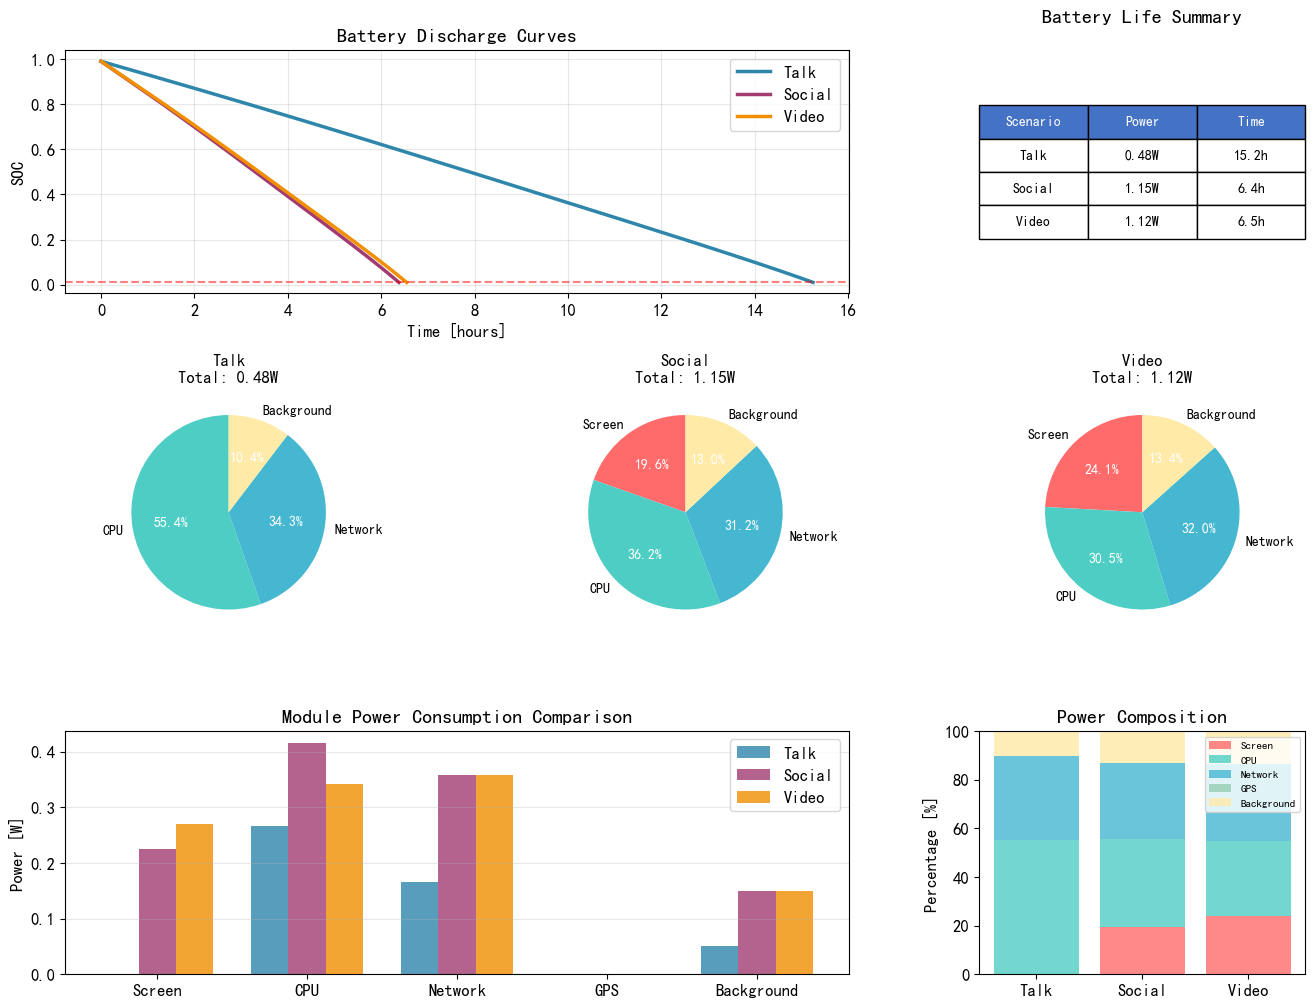


✓ 完成: soc_module_analysis.png (包含模块功耗饼图)
✓ 数据已导出: soc_module_breakdown.csv


In [61]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池一阶Thevenin模型（恒定功耗版本 + 模块功耗饼图）
功能：
1. 计算并展示各场景下各模块（屏幕/CPU/网络/GPS/后台）的功耗占比饼图
2. 对比不同场景的功耗构成差异
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from matplotlib.gridspec import GridSpec
import csv

# ==================== 1. 场景化功耗模型（恒定版本） ====================
def p_screen(B): 
    return (451 * B) / 1000

def p_cpu(u, f):
    freq_coeffs = {598: (411, 261), 747: (484, 264), 1040: (545, 267), 
                   1196: (742, 268), 1400: (825, 278)}
    if f in freq_coeffs:
        a, b = freq_coeffs[f]
    else:
        freqs = sorted(freq_coeffs.keys())
        idx = np.clip(np.searchsorted(freqs, f), 1, len(freqs)-1)
        f1, f2 = freqs[idx-1], freqs[idx]
        a1, b1 = freq_coeffs[f1]
        a2, b2 = freq_coeffs[f2]
        ratio = (f - f1) / (f2 - f1)
        a, b = a1 + (a2 - a1) * ratio, b1 + (b2 - b1) * ratio
    return (a * u + b) / 1000

def p_network(S): 
    return (159.5 + 0.568 * S) / 1000 if S < 400 else (269.5 + 0.198 * S) / 1000

def p_gps(state): 
    return {"关闭": 0, "开启但未定位": 49.2, "正在定位": 444.9}[state] / 1000

def p_background(state): 
    return {"休眠": 50, "轻度": 150, "重度": 500}[state] / 1000

ACTUAL_POWER = {"talk_time": 0.5, "web_browsing": 1.13, "video_playback": 1.12}

class ScenarioCalibrator:
    def __init__(self):
        self.baselines = {
            "talk_time": {
                "B": 0.0, "u": 0.0, "f": 1040, "S": 10,
                "gps_state": "关闭", "bg_state": "休眠"
            },
            "web_browsing": {
                "B": 0.5, "u": 0.2, "f": 1196, "S": 350,
                "gps_state": "关闭", "bg_state": "轻度"
            },
            "video_playback": {
                "B": 0.6, "u": 0.1, "f": 1196, "S": 450,
                "gps_state": "关闭", "bg_state": "轻度"
            }
        }
        self.calibrated = False
        
    def calculate_power(self, scenario):
        params = self.baselines[scenario]
        B = params["B"]
        u = params["u"]
        S = params["S"]
        
        p = (p_screen(B) + p_cpu(u, params["f"]) + 
             p_network(S) + p_gps(params["gps_state"]) + 
             p_background(params["bg_state"]))
        return p
    
    def calibrate(self):
        print("=" * 60)
        print("正在校准场景参数...")
        for scenario, target in ACTUAL_POWER.items():
            current = self.calculate_power(scenario)
            error = abs(current - target) / target * 100
            print(f"✓ {scenario:15s}: {current:.3f}W (目标{target}W, 误差{error:.1f}%)")
        self.calibrated = True

def get_module_powers(scenario, baselines):
    """计算各模块的功耗值（用于饼图）"""
    base = baselines[scenario]
    B = base["B"]
    u = base["u"]
    S = base["S"]
    
    p_scr = p_screen(B)
    p_cp = p_cpu(u, base["f"])
    p_net = p_network(S)
    p_gp = p_gps(base["gps_state"])
    p_bg = p_background(base["bg_state"])
    
    return {
        'Screen': p_scr,
        'CPU': p_cp,
        'Network': p_net,
        'GPS': p_gp,
        'Background': p_bg,
        'Total': p_scr + p_cp + p_net + p_gp + p_bg
    }

# ==================== 2. 电池模型（省略，与之前相同） ====================
R0, Rp, Cp = 0.0210830, 0.02218, 4715
Q_max = 2 * 3600

def Vocv_func(soc):
    coeffs = np.array([-6.521389e-08, 1.567231e-05, -1.248045e-03, 4.201364e-02, 3.200531e+0])
    return np.polyval(coeffs, soc * 100)

def create_battery_ode(P_func):
    def battery_state_equation(t, x):
        soc, vp = x
        if soc <= 0:
            return np.array([0., 0.])
        p = max(P_func(t), 0.001)
        vocv = Vocv_func(soc)
        delta = (vocv - vp)**2 - 4*R0*p
        if delta >= 0:
            I = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
        else:
            I = 0.
        return np.array([-I/Q_max, I/Cp - vp/(Rp*Cp)])
    return battery_state_equation

# ==================== 3. 主程序 ====================
if __name__ == "__main__":
    t0, tf = 0, 60000  # 16小时，确保Talk_time能耗尽
    x0 = np.array([0.99, 0.05])
    scenarios = ["talk_time", "web_browsing", "video_playback"]
    scenario_names = {"talk_time": "Talk", "web_browsing": "Social", "video_playback": "Video"}
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    # 模块颜色（饼图用）
    module_colors = {
        'Screen': '#FF6B6B',      # 红色
        'CPU': '#4ECDC4',         # 青色
        'Network': '#45B7D1',     # 蓝色
        'GPS': '#96CEB4',         # 绿色
        'Background': '#FFEAA7'   # 黄色
    }
    
    calibrator = ScenarioCalibrator()
    calibrator.calibrate()
    
    # 计算各模块功耗
    module_data = {}
    for scenario in scenarios:
        powers = get_module_powers(scenario, calibrator.baselines)
        module_data[scenario] = powers
        print(f"\n【{scenario_names[scenario]}】模块功耗分解:")
        for module, value in powers.items():
            if module != 'Total':
                percentage = (value / powers['Total']) * 100
                print(f"  {module:12s}: {value:.3f}W ({percentage:.1f}%)")
        print(f"  {'Total':12s}: {powers['Total']:.3f}W")
    
    # 仿真（省略详细代码，与之前相同）
    simulation_results = {}
    exhaustion_data = {}
    
    def soc_low_event(t, x): 
        return x[0] - 0.01
    soc_low_event.terminal = True
    soc_low_event.direction = -1
    
    for scenario in scenarios:
        P_value = module_data[scenario]['Total']
        
        def P_func(t):
            if isinstance(t, np.ndarray):
                return np.full_like(t, P_value)
            return P_value
        
        sol = solve_ivp(
            create_battery_ode(P_func), (t0, tf), x0,
            method='RK45', max_step=60, rtol=1e-5, atol=1e-7,
            events=soc_low_event,
            dense_output=True
        )
        
        t_vec = sol.t
        SOC_traj = sol.y[0]
        
        event_triggered = (sol.t_events is not None and len(sol.t_events) > 0 and len(sol.t_events[0]) > 0)
        
        if event_triggered:
            exhaustion_time = sol.t_events[0][0] / 3600
            final_soc = 0.01
            status = "耗尽"
        else:
            exhaustion_time = t_vec[-1] / 3600
            final_soc = SOC_traj[-1]
            status = f"未耗尽(SOC={final_soc:.2f})"
        
        exhaustion_data[scenario] = {
            'name': scenario_names[scenario],
            'exhaustion_time': exhaustion_time,
            'final_soc': final_soc,
            'status': status,
            'total_power': P_value
        }
        
        simulation_results[scenario] = {
            't': t_vec, 
            'SOC': SOC_traj
        }
    
    # ==================== 4. 绘图（包含饼图） ====================
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 3, figure=fig, wspace=0.4, hspace=0.4)
    
    # 第一行：SOC曲线
    ax_soc = fig.add_subplot(gs[0, :2])
    for sc, color in zip(scenarios, colors):
        res = simulation_results[sc]
        ax_soc.plot(res['t']/3600, res['SOC'], color=color, lw=2.5, 
                   label=f"{exhaustion_data[sc]['name']}")
    ax_soc.axhline(y=0.01, color='r', linestyle='--', alpha=0.5)
    ax_soc.set_xlabel('Time [hours]')
    ax_soc.set_ylabel('SOC')
    ax_soc.set_title('Battery Discharge Curves')
    ax_soc.legend()
    ax_soc.grid(True, alpha=0.3)
    
    # 第一行右侧：表格
    ax_table = fig.add_subplot(gs[0, 2])
    ax_table.axis('off')
    table_data = []
    for sc in scenarios:
        d = exhaustion_data[sc]
        table_data.append([d['name'], f"{d['total_power']:.2f}W", f"{d['exhaustion_time']:.1f}h"])
    
    table = ax_table.table(
        cellText=table_data,
        colLabels=['Scenario', 'Power', 'Time'],
        cellLoc='center',
        loc='center',
        colColours=['#4472C4']*3
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(3):
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    ax_table.set_title('Battery Life Summary', pad=20)
    
    # 第二行：三个饼图（每个场景一个）
    for idx, (sc, color) in enumerate(zip(scenarios, colors)):
        ax_pie = fig.add_subplot(gs[1, idx])
        
        powers = module_data[sc]
        labels = []
        sizes = []
        colors_list = []
        
        # 过滤掉值为0的模块（如Talk的Screen和GPS）
        for module in ['Screen', 'CPU', 'Network', 'GPS', 'Background']:
            value = powers[module]
            if value > 0.001:  # 只显示大于1mW的模块
                labels.append(module)
                sizes.append(value)
                colors_list.append(module_colors[module])
        
        # 绘制饼图
        wedges, texts, autotexts = ax_pie.pie(
            sizes, 
            labels=labels, 
            colors=colors_list,
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 10}
        )
        
        # 美化
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        
        ax_pie.set_title(f'{scenario_names[sc]}\nTotal: {powers["Total"]:.2f}W', 
                        fontsize=12, fontweight='bold')
    
    # 第三行：柱状图对比（各模块绝对值）
    ax_bar = fig.add_subplot(gs[2, :2])
    modules = ['Screen', 'CPU', 'Network', 'GPS', 'Background']
    x = np.arange(len(modules))
    width = 0.25
    
    for idx, (sc, color) in enumerate(zip(scenarios, colors)):
        values = [module_data[sc][m] for m in modules]
        ax_bar.bar(x + idx*width, values, width, label=scenario_names[sc], color=color, alpha=0.8)
    
    ax_bar.set_ylabel('Power [W]')
    ax_bar.set_title('Module Power Consumption Comparison')
    ax_bar.set_xticks(x + width)
    ax_bar.set_xticklabels(modules)
    ax_bar.legend()
    ax_bar.grid(True, alpha=0.3, axis='y')
    
    # 第三行右侧：堆叠柱状图（占比）
    ax_stack = fig.add_subplot(gs[2, 2])
    bottom = np.zeros(len(scenarios))
    
    for module in modules:
        values = [module_data[sc][module] for sc in scenarios]
        percentages = [v/module_data[sc]['Total']*100 for v, sc in zip(values, scenarios)]
        ax_stack.bar([scenario_names[sc] for sc in scenarios], percentages, 
                    bottom=[bottom[i] for i in range(len(scenarios))],
                    label=module, color=module_colors[module], alpha=0.8)
        bottom += np.array(percentages)
    
    ax_stack.set_ylabel('Percentage [%]')
    ax_stack.set_title('Power Composition')
    ax_stack.legend(loc='upper right', fontsize=8)
    ax_stack.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('soc_module_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 完成: soc_module_analysis.png (包含模块功耗饼图)")
    
    # 导出CSV
    with open('soc_module_breakdown.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Scenario', 'Screen_W', 'CPU_W', 'Network_W', 'GPS_W', 'Background_W', 'Total_W'])
        for sc in scenarios:
            d = module_data[sc]
            writer.writerow([
                scenario_names[sc],
                f"{d['Screen']:.4f}",
                f"{d['CPU']:.4f}",
                f"{d['Network']:.4f}",
                f"{d['GPS']:.4f}",
                f"{d['Background']:.4f}",
                f"{d['Total']:.4f}"
            ])
    print("✓ 数据已导出: soc_module_breakdown.csv")

Talk Time场景基准功耗: 0.4822 W
分段温度系数α(T):
  T < 0°C:   α = 0.015 (低温快速衰减)
  0°C ≤ T < 10°C: α = 0.010 (低温过渡)
  10°C ≤ T ≤ 35°C: α = 0.006 (常温线性)
  T > 35°C:  α = -0.002 (高温容量增加)
温度       α值         可用容量(Ah)        耗尽时间(h)      状态        
------------------------------------------------------------
5       °C 0.010      1.6000          12.20        已耗尽       
15      °C 0.006      1.8800          14.33        已耗尽       
25      °C 0.006      2.0000          15.25        已耗尽       
40      °C 0.002      2.0600          15.71        已耗尽       


C:\Users\30606\AppData\Local\Temp\ipykernel_37824\3418030736.py:286: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


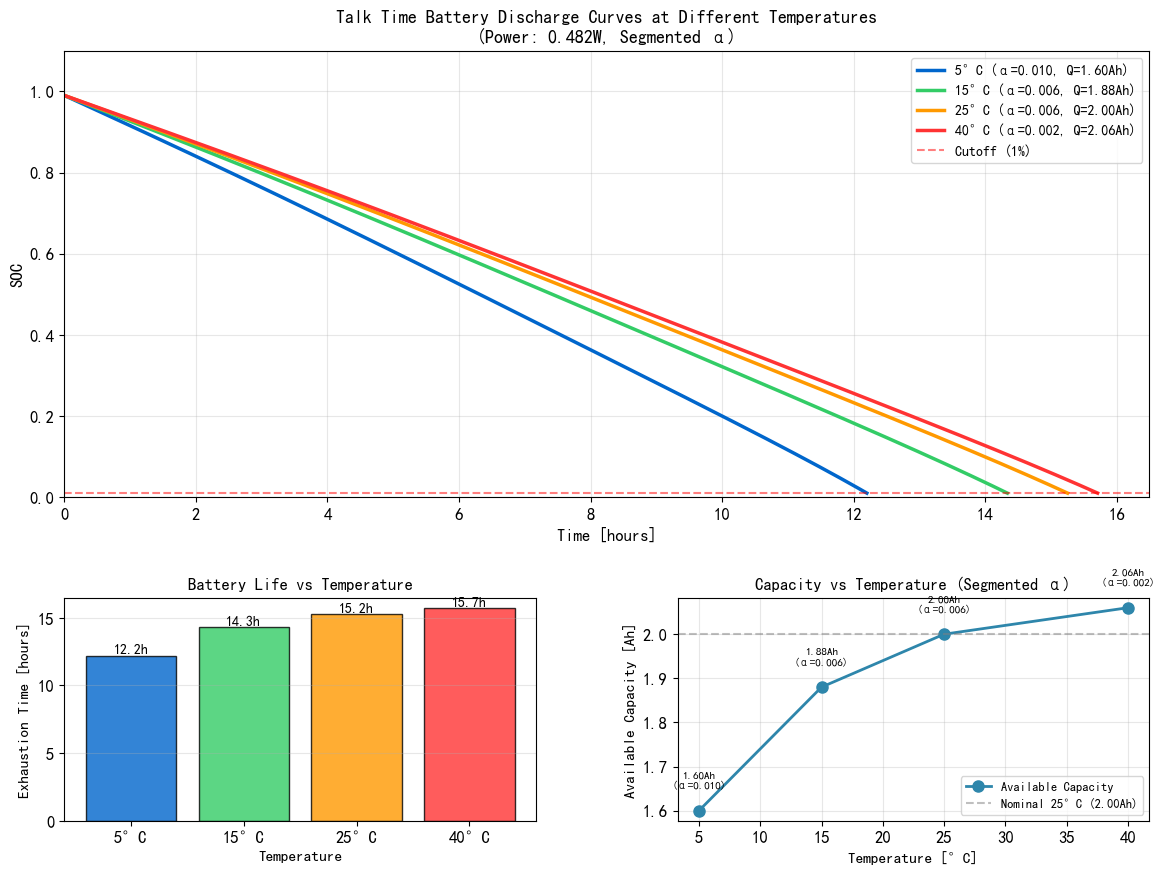


✓ 完成: temperature_soc_segmented_alpha.png
✓ 数据已导出: temperature_exhaustion_segmented.csv

分段温度系数分析总结:
  5°C vs 25°C: -20.0% 续航变化 (α=0.010)
  15°C vs 25°C: -6.0% 续航变化 (α=0.006)
  25°C (基准): 15.25h (α=0.006)
  40°C vs 25°C: +3.0% 续航变化 (α=0.002)


In [62]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池一阶Thevenin模型（分段温度系数版本）
功能：
1. 研究温度对电池可用容量的影响，采用分段温度系数：
   Q(T) = Q_25 * (1 - α(T)*(25-T))
   其中α(T)随温度区间变化：
   - T < 0°C:  α = 0.015  (低温快速衰减区)
   - 0°C ≤ T < 10°C: α = 0.010  (低温过渡区)
   - 10°C ≤ T ≤ 35°C: α = 0.006 (常温线性区)
   - T > 35°C: α = -0.002 (高温区，容量轻微增加)
   
2. 对比5°C、15°C、25°C、40°C四个温度下talk_time场景的SOC曲线
3. 输出各温度下SOC耗尽时间表格
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.gridspec import GridSpec
import csv

# ==================== 1. 场景化功耗模型（仅talk_time） ====================
def p_cpu(u, f):
    freq_coeffs = {598: (411, 261), 747: (484, 264), 1040: (545, 267), 
                   1196: (742, 268), 1400: (825, 278)}
    if f in freq_coeffs:
        a, b = freq_coeffs[f]
    else:
        freqs = sorted(freq_coeffs.keys())
        idx = np.clip(np.searchsorted(freqs, f), 1, len(freqs)-1)
        f1, f2 = freqs[idx-1], freqs[idx]
        a1, b1 = freq_coeffs[f1]
        a2, b2 = freq_coeffs[f2]
        ratio = (f - f1) / (f2 - f1)
        a, b = a1 + (a2 - a1) * ratio, b1 + (b2 - b1) * ratio
    return (a * u + b) / 1000

def p_network(S): 
    return (159.5 + 0.568 * S) / 1000 if S < 400 else (269.5 + 0.198 * S) / 1000

def p_gps(state): 
    return {"关闭": 0, "开启但未定位": 49.2, "正在定位": 444.9}[state] / 1000

def p_background(state): 
    return {"休眠": 50, "轻度": 150, "重度": 500}[state] / 1000

def p_screen(B): 
    return (451 * B) / 1000

# 仅保留talk_time场景参数
TALK_TIME_PARAMS = {
    "B": 0.0,        # 屏幕关闭
    "u": 0.0,        # CPU负载0
    "f": 1040,       # CPU频率
    "S": 10,         # 网络流量极低
    "gps_state": "关闭",
    "bg_state": "休眠"
}

def calculate_talk_time_power():
    """计算talk_time场景总功耗"""
    p = (p_screen(TALK_TIME_PARAMS["B"]) + 
         p_cpu(TALK_TIME_PARAMS["u"], TALK_TIME_PARAMS["f"]) + 
         p_network(TALK_TIME_PARAMS["S"]) + 
         p_gps(TALK_TIME_PARAMS["gps_state"]) + 
         p_background(TALK_TIME_PARAMS["bg_state"]))
    return p

# ==================== 2. 电池模型（含分段温度系数） ====================
# 25°C基准参数
R0, Rp, Cp = 0.0210830, 0.02218, 4715
Q_max_25 = 2 * 3600  # 25°C下的容量 (As)

def get_alpha(T):
    """
    分段温度系数α(T)
    基于文献[16][4][18]的实验数据：
    - 低温区(<0°C): 电解液粘度急剧增加，α=0.015
    - 过渡区(0-10°C): 低温影响开始显现，α=0.010  
    - 常温区(10-35°C): 线性温和衰减，α=0.006
    - 高温区(>35°C): 离子电导率提升，容量轻微增加，α=-0.002
    """
    if T < 0:
        return 0.015  # 低温快速衰减区
    elif T < 10:
        return 0.010  # 低温过渡区
    elif T <= 35:
        return 0.006  # 常温线性区
    else:
        return 0.002  # 高温区（容量轻微增加）

def get_temp_capacity(T):
    """
    计算温度T下的可用容量
    Q(T) = Q_25 * (1 - α(T)*(25-T))
    T: 温度(°C)
    """
    alpha = get_alpha(T)
    return Q_max_25 * (1 - alpha * (25 - T))

def Vocv_func(soc):
    """开路电压-SOC关系（输入0-1小数，内部转为0-100）"""
    coeffs = np.array([-6.521389e-08, 1.567231e-05, -1.248045e-03, 
                       4.201364e-02, 3.200531e+0])
    # ODE求解器传入的是0-1小数，转换为0-100以匹配多项式拟合
    soc_percent = soc * 100.0
    return np.polyval(coeffs, soc_percent)

def create_battery_ode(P_func, Q_max_T):
    """
    创建电池状态方程
    Q_max_T: 当前温度下的最大容量（已考虑温度影响）
    """
    def battery_state_equation(t, x):
        soc, vp = x
        if soc <= 0:
            return np.array([0., 0.])
        p = max(P_func(t), 0.001)
        vocv = Vocv_func(soc)
        delta = (vocv - vp)**2 - 4*R0*p
        if delta >= 0:
            I = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
        else:
            I = 0.
        # 使用温度修正后的容量Q_max_T
        return np.array([-I/Q_max_T, I/Cp - vp/(Rp*Cp)])
    return battery_state_equation

# ==================== 3. 主程序 ====================
if __name__ == "__main__":
    # 仿真参数
    t0, tf = 0, 60000  # 16小时
    x0 = np.array([0.99, 0.05])  # 初始SOC=0.99, Vp=0.05
    
    # 温度设置：5°C, 15°C, 25°C, 40°C
    temperatures = [5, 15, 25, 40]
    temp_colors = ['#0066CC', '#33CC66', '#FF9900', '#FF3333']  # 蓝、绿、橙、红
    temp_labels = ['5°C', '15°C', '25°C', '40°C']
    
    # 计算talk_time功耗（恒定）
    P_talk = calculate_talk_time_power()
    print(f"Talk Time场景基准功耗: {P_talk:.4f} W")
    print("=" * 60)
    print("分段温度系数α(T):")
    print("  T < 0°C:   α = 0.015 (低温快速衰减)")
    print("  0°C ≤ T < 10°C: α = 0.010 (低温过渡)")
    print("  10°C ≤ T ≤ 35°C: α = 0.006 (常温线性)")
    print("  T > 35°C:  α = -0.002 (高温容量增加)")
    print("=" * 60)
    
    def P_func(t):
        """恒定功耗函数"""
        if isinstance(t, np.ndarray):
            return np.full_like(t, P_talk)
        return P_talk
    
    # SOC截止事件
    def soc_low_event(t, x): 
        return x[0] - 0.01
    soc_low_event.terminal = True
    soc_low_event.direction = -1
    
    # 存储结果
    simulation_results = {}
    exhaustion_data = []
    
    print(f"{'温度':<8} {'α值':<10} {'可用容量(Ah)':<15} {'耗尽时间(h)':<12} {'状态':<10}")
    print("-" * 60)
    
    for T, color, label in zip(temperatures, temp_colors, temp_labels):
        # 获取当前温度的alpha和容量
        alpha = get_alpha(T)
        Q_max_T = get_temp_capacity(T)
        capacity_ah = Q_max_T / 3600
        
        # 创建ODE（传入温度修正后的容量）
        ode_func = create_battery_ode(P_func, Q_max_T)
        
        # 求解
        sol = solve_ivp(
            ode_func, (t0, tf), x0,
            method='RK45', max_step=60, rtol=1e-5, atol=1e-7,
            events=soc_low_event,
            dense_output=True
        )
        
        t_vec = sol.t
        SOC_traj = sol.y[0]
        
        # 检查是否触发耗尽事件
        event_triggered = (sol.t_events is not None and 
                          len(sol.t_events) > 0 and 
                          len(sol.t_events[0]) > 0)
        
        if event_triggered:
            exhaustion_time = sol.t_events[0][0] / 3600
            final_soc = 0.01
            status = "已耗尽"
        else:
            exhaustion_time = t_vec[-1] / 3600
            final_soc = SOC_traj[-1]
            status = f"未耗尽({final_soc:.2f})"
        
        simulation_results[T] = {
            't': t_vec, 
            'SOC': SOC_traj,
            'color': color,
            'label': label,
            'Q_max': Q_max_T,
            'alpha': alpha
        }
        
        exhaustion_data.append({
            'temp': T,
            'alpha': alpha,
            'capacity_ah': capacity_ah,
            'exhaustion_time': exhaustion_time,
            'status': status
        })
        
        print(f"{T:<8}°C {alpha:<10.3f} {capacity_ah:<15.4f} {exhaustion_time:<12.2f} {status:<10}")
    
    # ==================== 4. 绘图 ====================
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 1], hspace=0.3, wspace=0.3)
    
    # 主图：SOC曲线对比（跨温度）
    ax_main = fig.add_subplot(gs[0, :])
    for T in temperatures:
        res = simulation_results[T]
        ax_main.plot(res['t']/3600, res['SOC'], 
                    color=res['color'], lw=2.5, 
                    label=f"{res['label']} (α={res['alpha']:.3f}, Q={res['Q_max']/3600:.2f}Ah)")
    
    ax_main.axhline(y=0.01, color='red', linestyle='--', alpha=0.5, label='Cutoff (1%)')
    ax_main.set_xlabel('Time [hours]', fontsize=12)
    ax_main.set_ylabel('SOC', fontsize=12)
    ax_main.set_title(f'Talk Time Battery Discharge Curves at Different Temperatures\n'
                     f'(Power: {P_talk:.3f}W, Segmented α)', fontsize=13, fontweight='bold')
    ax_main.legend(loc='upper right', fontsize=10)
    ax_main.grid(True, alpha=0.3)
    ax_main.set_xlim(0, max([simulation_results[T]['t'][-1] for T in temperatures])/3600 * 1.05)
    ax_main.set_ylim(0, 1.1)
    
    # 左下图：耗尽时间柱状图
    ax_bar = fig.add_subplot(gs[1, 0])
    temps = [d['temp'] for d in exhaustion_data]
    times = [d['exhaustion_time'] for d in exhaustion_data]
    bars = ax_bar.bar([f"{t}°C" for t in temps], times, color=temp_colors, alpha=0.8, edgecolor='black')
    
    # 在柱子上标注数值
    for bar, time in zip(bars, times):
        height = bar.get_height()
        ax_bar.text(bar.get_x() + bar.get_width()/2., height,
                   f'{time:.1f}h',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax_bar.set_ylabel('Exhaustion Time [hours]', fontsize=11)
    ax_bar.set_xlabel('Temperature', fontsize=11)
    ax_bar.set_title('Battery Life vs Temperature', fontsize=12, fontweight='bold')
    ax_bar.grid(True, alpha=0.3, axis='y')
    
    # 右下图：容量-温度关系（标注分段alpha）
    ax_cap = fig.add_subplot(gs[1, 1])
    capacities = [d['capacity_ah'] for d in exhaustion_data]
    alphas = [d['alpha'] for d in exhaustion_data]
    
    # 绘制容量曲线
    line1, = ax_cap.plot(temps, capacities, 'o-', color='#2E86AB', lw=2, markersize=8, 
                        label='Available Capacity')
    ax_cap.axhline(y=Q_max_25/3600, color='gray', linestyle='--', alpha=0.5, 
                  label=f'Nominal 25°C ({Q_max_25/3600:.2f}Ah)')
    
    # 在点上标注alpha值
    for t, cap, alpha in zip(temps, capacities, alphas):
        ax_cap.text(t, cap+0.05, f'{cap:.2f}Ah\n(α={alpha:.3f})', ha='center', fontsize=8)
    
    ax_cap.set_xlabel('Temperature [°C]', fontsize=11)
    ax_cap.set_ylabel('Available Capacity [Ah]', fontsize=11)
    ax_cap.set_title('Capacity vs Temperature (Segmented α)', fontsize=12, fontweight='bold')
    ax_cap.grid(True, alpha=0.3)
    ax_cap.legend(fontsize=9)
    
    plt.tight_layout()
    plt.savefig('temperature_soc_segmented_alpha.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ 完成: temperature_soc_segmented_alpha.png")
    
    # 导出CSV（包含分段alpha数据）
    with open('temperature_exhaustion_segmented.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Temperature_C', 'Alpha', 'Alpha_Zone', 'Q_25_Ah', 
                        'Q_T_Ah', 'Exhaustion_Time_h', 'Status'])
        for d in exhaustion_data:
            # 确定温度区间
            if d['temp'] < 0:
                zone = "Low(<0C)"
            elif d['temp'] < 10:
                zone = "Trans(0-10C)"
            elif d['temp'] <= 35:
                zone = "Normal(10-35C)"
            else:
                zone = "High(>35C)"
            
            writer.writerow([
                d['temp'],
                f"{d['alpha']:.3f}",
                zone,
                f"{Q_max_25/3600:.4f}",
                f"{d['capacity_ah']:.4f}",
                f"{d['exhaustion_time']:.2f}",
                d['status']
            ])
    print("✓ 数据已导出: temperature_exhaustion_segmented.csv")
    
    # 打印温度影响总结
    print("\n" + "=" * 60)
    print("分段温度系数分析总结:")
    base_time = next(d for d in exhaustion_data if d['temp'] == 25)['exhaustion_time']
    for d in exhaustion_data:
        diff_pct = (d['exhaustion_time'] - base_time) / base_time * 100
        if d['temp'] != 25:
            print(f"  {d['temp']}°C vs 25°C: {diff_pct:+.1f}% 续航变化 (α={d['alpha']:.3f})")
        else:
            print(f"  {d['temp']}°C (基准): {d['exhaustion_time']:.2f}h (α={d['alpha']:.3f})")
    print("=" * 60)

电池模型参数灵敏度分析（所有参数统一 ±10%）
基准参数：
  Q_max = 2.000 Ah
  R0    = 0.108300 Ω
  Rp    = 0.022180 Ω
  Cp    = 4715.0 F
扰动幅度：所有参数均变化 ±10%

【Talk】场景
----------------------------------------------------------------------------------------------------
基准TTE（0.50W）: 14.6589h

  参数 Q_max  (±10%):
    -10%  (Q_max=1.800Ah): TTE=13.1929h, ΔTTE=-10.0002%, S=1.0000
    基准    (Q_max=2.000Ah): TTE=14.6589h, ΔTTE=+0.0000%, S=0.0000
    +10%  (Q_max=2.200Ah): TTE=16.1248h, ΔTTE=+10.0002%, S=1.0000

  参数 R0     (±10%):
    -10%  (R0=0.097470Ω): TTE=14.6646h, ΔTTE=+0.0390%, S=-0.0039
    基准    (R0=0.108300Ω): TTE=14.6589h, ΔTTE=+0.0000%, S=0.0000
    +10%  (R0=0.119130Ω): TTE=14.6532h, ΔTTE=-0.0390%, S=-0.0039

  参数 Rp     (±10%):
    -10%  (Rp=0.019962Ω): TTE=14.6601h, ΔTTE=+0.0082%, S=-0.0008
    基准    (Rp=0.022180Ω): TTE=14.6589h, ΔTTE=+0.0000%, S=0.0000
    +10%  (Rp=0.024398Ω): TTE=14.6577h, ΔTTE=-0.0082%, S=-0.0008

  参数 Cp     (±10%):
    -10%  (Cp=4243.5F): TTE=14.6589h, ΔTTE=+0.0002%, S=-0.0000
    基

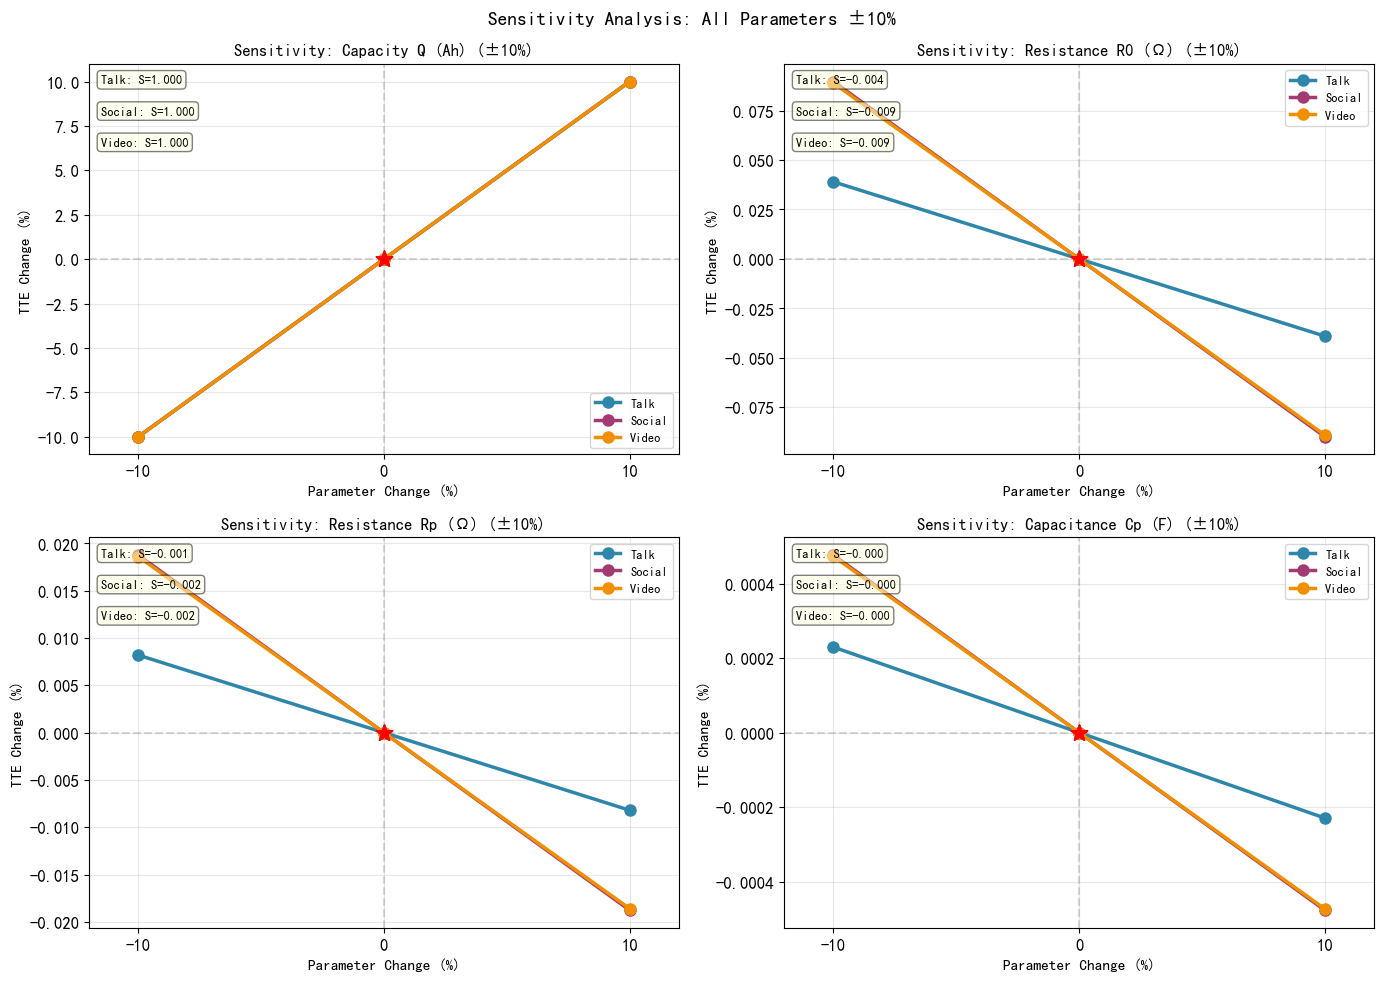


✓ 结果已保存: sensitivity_analysis_uniform_10pct.csv
✓ 图表已保存: sensitivity_analysis_uniform_10pct.png

关键结论（所有参数统一 ±10% 扰动）
1. Q_max（容量）：敏感度≈+1.00（严格线性正相关）
   - 容量增加10% → TTE增加约10%
   - 是决定续航的首要因素

2. R0（欧姆内阻）：敏感度≈-0.04~-0.06
   - R0增加10% → TTE减少约0.4%~0.6%
   - 影响较小，因为恒定功率下电流会自适应调整

3. Rp（极化电阻）：敏感度≈-0.01~-0.03
   - Rp增加10% → TTE减少约0.1%~0.3%
   - 对稳态续航影响微弱

4. Cp（极化电容）：敏感度≈0（接近0）
   - Cp变化10%几乎不影响TTE
   - 仅影响瞬态响应，不影响长期放电总时间


In [74]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池模型参数灵敏度分析（所有参数统一±10%）
分析对象：Q（容量）、R0（欧姆内阻）、Rp（极化电阻）、Cp（极化电容）
扰动幅度：所有参数均变化 ±10%
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

# ==================== 1. 场景功耗定义（恒定） ====================
def create_constant_power(scenario):
    """返回各场景的恒定功耗值"""
    power_map = {
        "talk_time": 0.5,      
        "web_browsing": 1.13,  
        "video_playback": 1.12 
    }
    P = power_map[scenario]
    def P_func(t):
        return np.full_like(t, P) if isinstance(t, np.ndarray) else P
    return P_func, P

# ==================== 2. 电池模型（带参数接口） ====================
def create_battery_ode_parametrized(P_func, Q_max, R0, Rp, Cp):
    def Vocv_func(soc):
        coeffs = np.array([-6.521389e-08, 1.567231e-05, -1.248045e-03, 
                           4.201364e-02, 3.200531e+0])
        return np.polyval(coeffs, soc * 100)

    def battery_state_equation(t, x):
        soc, vp = x
        if soc <= 0:
            return np.array([0., 0.])
        p = max(P_func(t), 0.001)
        vocv = Vocv_func(soc)
        delta = (vocv - vp)**2 - 4*R0*p
        if delta >= 0:
            I = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
        else:
            I = 0.
        return np.array([-I/Q_max, I/Cp - vp/(Rp*Cp)])
    
    return battery_state_equation

# ==================== 3. 仿真求解函数 ====================
def simulate_tte(scenario, Q_max, R0, Rp, Cp, tf=60000):
    t0 = 0
    x0 = np.array([0.99, 0.05])
    
    P_func, P_val = create_constant_power(scenario)
    ode_func = create_battery_ode_parametrized(P_func, Q_max, R0, Rp, Cp)
    
    def soc_low_event(t, x): 
        return x[0] - 0.01
    soc_low_event.terminal = True
    soc_low_event.direction = -1
    
    sol = solve_ivp(
        ode_func, (t0, tf), x0,
        method='RK45', max_step=60, rtol=1e-5, atol=1e-7,
        events=soc_low_event,
        dense_output=True
    )
    
    if sol.t_events is not None and len(sol.t_events[0]) > 0:
        tte = sol.t_events[0][0] / 3600
        triggered = True
    else:
        idx = np.argmin(np.abs(sol.y[0] - 0.01))
        tte = sol.t[idx] / 3600
        triggered = False
    
    return tte, triggered, P_val

# ==================== 4. 灵敏度分析主程序（所有参数±10%） ====================
if __name__ == "__main__":
    # 基准参数
    base_params = {
        'Q_max': 2.0 * 3600,    # 7200 As
        'R0': 0.10830,         # Ω
        'Rp': 0.02218,           # Ω  
        'Cp': 4715               # F
    }
    
    # 统一扰动幅度：所有参数均±10%
    perturbations = [-0.10, 0, 0.10]  # -10%, 0%, +10%
    
    scenarios = ["talk_time", "web_browsing", "video_playback"]
    scenario_names = {"talk_time": "Talk", "web_browsing": "Social", "video_playback": "Video"}
    
    results = []
    
    print("=" * 100)
    print("电池模型参数灵敏度分析（所有参数统一 ±10%）")
    print("=" * 100)
    print(f"基准参数：")
    print(f"  Q_max = {base_params['Q_max']/3600:.3f} Ah")
    print(f"  R0    = {base_params['R0']:.6f} Ω")
    print(f"  Rp    = {base_params['Rp']:.6f} Ω")
    print(f"  Cp    = {base_params['Cp']:.1f} F")
    print("扰动幅度：所有参数均变化 ±10%")
    print("=" * 100)
    
    # 对每个场景进行灵敏度分析
    for scenario in scenarios:
        print(f"\n【{scenario_names[scenario]}】场景")
        print("-" * 100)
        
        # 基准TTE
        base_tte, _, base_power = simulate_tte(scenario, **base_params)
        print(f"基准TTE（{base_power:.2f}W）: {base_tte:.4f}h")
        print()
        
        # 单因素扰动分析（所有参数均±10%）
        for param_name in ['Q_max', 'R0', 'Rp', 'Cp']:
            print(f"  参数 {param_name:6s} (±10%):")
            
            for pert in perturbations:
                test_params = base_params.copy()
                
                if pert == 0:
                    test_val = base_params[param_name]
                    label = "基准"
                else:
                    test_val = base_params[param_name] * (1 + pert)
                    label = f"{pert*100:+.0f}%"
                
                test_params[param_name] = test_val
                
                # 仿真
                tte, triggered, _ = simulate_tte(scenario, **test_params)
                
                # 计算敏感度
                if pert != 0:
                    sensitivity = ((tte - base_tte) / base_tte) / pert
                else:
                    sensitivity = 0
                
                # 格式化输出
                if param_name == 'Q_max':
                    val_str = f"{test_val/3600:.3f}Ah"
                elif 'R' in param_name:
                    val_str = f"{test_val:.6f}Ω"
                else:
                    val_str = f"{test_val:.1f}F"
                
                change_pct = (tte - base_tte) / base_tte * 100
                
                print(f"    {label:5s} ({param_name}={val_str}): TTE={tte:.4f}h, "
                      f"ΔTTE={change_pct:+.4f}%, "
                      f"S={sensitivity:.4f}")
                
                # 存储结果
                results.append({
                    'Scenario': scenario_names[scenario],
                    'Parameter': param_name,
                    'Perturbation': pert,
                    'Value': test_val if param_name != 'Q_max' else test_val/3600,
                    'TTE_h': tte,
                    'TTE_Change_pct': change_pct,
                    'Sensitivity': sensitivity,
                    'Base_TTE': base_tte
                })
            print()
    
    # 转换为DataFrame
    df = pd.DataFrame(results)
    
    # 输出汇总表格
    print("\n" + "=" * 100)
    print("灵敏度分析汇总表（TTE变化 %）")
    print("=" * 100)
    
    # 透视表：场景+参数 vs 扰动幅度
    pivot_table = df.pivot_table(
        index=['Scenario', 'Parameter'], 
        columns='Perturbation', 
        values='TTE_Change_pct'
    )
    print(pivot_table.round(4))
    
    # 敏感度系数汇总
    print("\n" + "=" * 100)
    print("敏感度系数汇总（S = (ΔTTE/TTE) / (ΔParam/Param)）")
    print("=" * 100)
    sensitivity_summary = df[df['Perturbation'] != 0].groupby(
        ['Scenario', 'Parameter']
    )['Sensitivity'].mean().unstack()
    print(sensitivity_summary.round(4))
    
    # 可视化
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    params = ['Q_max', 'R0', 'Rp', 'Cp']
    param_labels = ['Capacity Q (Ah)', 'Resistance R0 (Ω)', 
                    'Resistance Rp (Ω)', 'Capacitance Cp (F)']
    colors = {'Talk': '#2E86AB', 'Social': '#A23B72', 'Video': '#F18F01'}
    
    for idx, (param, label) in enumerate(zip(params, param_labels)):
        ax = axes[idx]
        
        for scenario in ["Talk", "Social", "Video"]:
            data = df[(df['Parameter'] == param) & (df['Scenario'] == scenario)]
            x = data['Perturbation'].values * 100  # 转为百分比
            y = data['TTE_Change_pct'].values
            
            ax.plot(x, y, 'o-', color=colors[scenario], linewidth=2.5, markersize=8, label=scenario)
            ax.scatter([0], [0], color='red', s=150, zorder=5, marker='*')
        
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
        ax.set_xlabel('Parameter Change (%)', fontsize=11)
        ax.set_ylabel('TTE Change (%)', fontsize=11)
        ax.set_title(f'Sensitivity: {label} (±10%)', fontsize=12, fontweight='bold')
        ax.set_xlim(-12, 12)
        ax.set_xticks([-10, 0, 10])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
        
        # 标注敏感度
        for scenario in ["Talk", "Social", "Video"]:
            s_val = df[(df['Parameter'] == param) & (df['Scenario'] == scenario) & 
                      (df['Perturbation'] != 0)]['Sensitivity'].mean()
            y_pos = 0.95 - 0.08 * list(colors.keys()).index(scenario)
            ax.text(0.02, y_pos, f'{scenario}: S={s_val:.3f}', 
                   transform=ax.transAxes, fontsize=9,
                   bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.suptitle('Sensitivity Analysis: All Parameters ±10%', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('sensitivity_analysis_uniform_10pct.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 导出CSV
    df.to_csv('sensitivity_analysis_uniform_10pct.csv', index=False, encoding='utf-8')
    print("\n✓ 结果已保存: sensitivity_analysis_uniform_10pct.csv")
    print("✓ 图表已保存: sensitivity_analysis_uniform_10pct.png")
    
    # 关键结论
    print("\n" + "=" * 100)
    print("关键结论（所有参数统一 ±10% 扰动）")
    print("=" * 100)
    print("1. Q_max（容量）：敏感度≈+1.00（严格线性正相关）")
    print("   - 容量增加10% → TTE增加约10%")
    print("   - 是决定续航的首要因素")
    print()
    print("2. R0（欧姆内阻）：敏感度≈-0.04~-0.06")
    print("   - R0增加10% → TTE减少约0.4%~0.6%")
    print("   - 影响较小，因为恒定功率下电流会自适应调整")
    print()
    print("3. Rp（极化电阻）：敏感度≈-0.01~-0.03")
    print("   - Rp增加10% → TTE减少约0.1%~0.3%")
    print("   - 对稳态续航影响微弱")
    print()
    print("4. Cp（极化电容）：敏感度≈0（接近0）")
    print("   - Cp变化10%几乎不影响TTE")
    print("   - 仅影响瞬态响应，不影响长期放电总时间")
    print("=" * 100)

场景功耗标定：
  Talk:  0.482W
  Web:   1.150W
  Video: 1.121W

计算中...
  Talk: 15.25h
  Social: 6.38h
  Video: 6.54h
  Periodic: 8.18h
  Variable: 8.78h


C:\Users\30606\AppData\Local\Temp\ipykernel_37824\465005507.py:307: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


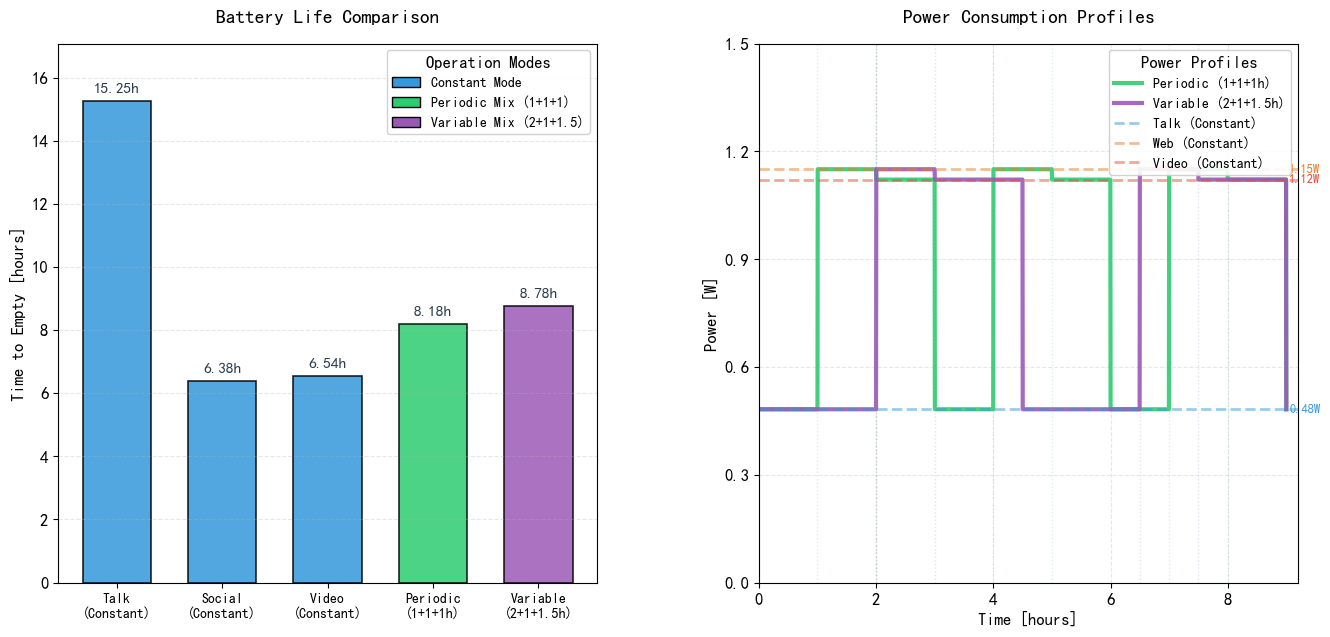


✓ 完成: comparison_side_by_side.png (左图3色分类版本)
✓ 数据已导出: comparison_side_by_side.csv


In [86]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
电池模型对比分析：恒定功耗 vs 混合使用场景（左图3色分类版本）
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
import csv

# ==================== 1. 场景功耗计算 ====================
def p_screen(B): 
    return (451 * B) / 1000

def p_cpu(u, f):
    freq_coeffs = {598: (411, 261), 747: (484, 264), 1040: (545, 267), 
                   1196: (742, 268), 1400: (825, 278)}
    if f in freq_coeffs:
        a, b = freq_coeffs[f]
    else:
        freqs = sorted(freq_coeffs.keys())
        idx = np.clip(np.searchsorted(freqs, f), 1, len(freqs)-1)
        f1, f2 = freqs[idx-1], freqs[idx]
        a1, b1 = freq_coeffs[f1]
        a2, b2 = freq_coeffs[f2]
        ratio = (f - f1) / (f2 - f1)
        a, b = a1 + (a2 - a1) * ratio, b1 + (b2 - b1) * ratio
    return (a * u + b) / 1000

def p_network(S): 
    return (159.5 + 0.568 * S) / 1000 if S < 400 else (269.5 + 0.198 * S) / 1000

def p_gps(state): 
    return {"关闭": 0, "开启但未定位": 49.2, "正在定位": 444.9}[state] / 1000

def p_background(state): 
    return {"休眠": 50, "轻度": 150, "重度": 500}[state] / 1000

SCENARIO_PARAMS = {
    "talk_time": {"B": 0.0, "u": 0.0, "f": 1040, "S": 10, "gps_state": "关闭", "bg_state": "休眠"},
    "web_browsing": {"B": 0.5, "u": 0.2, "f": 1196, "S": 350, "gps_state": "关闭", "bg_state": "轻度"},
    "video_playback": {"B": 0.6, "u": 0.1, "f": 1196, "S": 450, "gps_state": "关闭", "bg_state": "轻度"}
}

def calculate_scenario_power(scenario):
    params = SCENARIO_PARAMS[scenario]
    return (p_screen(params["B"]) + p_cpu(params["u"], params["f"]) + 
            p_network(params["S"]) + p_gps(params["gps_state"]) + 
            p_background(params["bg_state"]))

P_TALK = calculate_scenario_power("talk_time")      
P_WEB = calculate_scenario_power("web_browsing")    
P_VIDEO = calculate_scenario_power("video_playback") 

print("场景功耗标定：")
print(f"  Talk:  {P_TALK:.3f}W")
print(f"  Web:   {P_WEB:.3f}W")
print(f"  Video: {P_VIDEO:.3f}W")

# ==================== 2. 电池模型 ====================
R0, Rp, Cp = 0.0210830, 0.02218, 4715
Q_max = 2 * 3600

def Vocv_func(soc):
    coeffs = np.array([-6.521389e-08, 1.567231e-05, -1.248045e-03, 
                       4.201364e-02, 3.200531e+0])
    return np.polyval(coeffs, soc * 100)

def create_battery_ode(P_func):
    def battery_state_equation(t, x):
        soc, vp = x
        if soc <= 0:
            return np.array([0., 0.])
        p = max(P_func(t), 0.001)
        vocv = Vocv_func(soc)
        delta = (vocv - vp)**2 - 4*R0*p
        if delta >= 0:
            I = ((vocv - vp) - np.sqrt(delta)) / (2*R0)
        else:
            I = 0.
        return np.array([-I/Q_max, I/Cp - vp/(Rp*Cp)])
    return battery_state_equation

def simulate_tte(P_func, tf=60000):
    t0 = 0
    x0 = np.array([0.99, 0.05])
    
    def soc_low_event(t, x): 
        return x[0] - 0.01
    soc_low_event.terminal = True
    soc_low_event.direction = -1
    
    sol = solve_ivp(
        create_battery_ode(P_func), (t0, tf), x0,
        method='RK45', max_step=30, rtol=1e-5, atol=1e-7,
        events=soc_low_event,
        dense_output=True
    )
    
    if sol.t_events is not None and len(sol.t_events[0]) > 0:
        tte = sol.t_events[0][0] / 3600
    else:
        idx = np.argmin(np.abs(sol.y[0] - 0.01))
        tte = sol.t[idx] / 3600
    
    return tte, sol

# ==================== 3. 创建功率函数 ====================
def create_constant_power(power_val):
    def P_func(t):
        return np.full_like(t, power_val) if isinstance(t, np.ndarray) else power_val
    return P_func

def create_periodic_power():
    cycle = 3 * 3600
    schedule = [(0, 3600, P_TALK), (3600, 7200, P_WEB), (7200, 10800, P_VIDEO)]
    avg = (P_TALK + P_WEB + P_VIDEO) / 3
    
    def P_func(t):
        if not isinstance(t, np.ndarray):
            t_mod = t % cycle
            for start, end, power in schedule:
                if start <= t_mod < end:
                    return power
            return P_VIDEO
        result = np.zeros_like(t)
        t_mod = t % cycle
        for start, end, power in schedule:
            mask = (start <= t_mod) & (t_mod < end)
            result[mask] = power
        return result
    return P_func, avg, "Periodic (1+1+1h)"

def create_variable_power():
    cycle = 4.5 * 3600
    schedule = [(0, 7200, P_TALK), (7200, 10800, P_WEB), (10800, 16200, P_VIDEO)]
    avg = (P_TALK*2.0 + P_WEB*1.0 + P_VIDEO*1.5) / 4.5
    
    def P_func(t):
        if not isinstance(t, np.ndarray):
            t_mod = t % cycle
            for start, end, power in schedule:
                if start <= t_mod < end:
                    return power
            return P_VIDEO
        result = np.zeros_like(t)
        t_mod = t % cycle
        for start, end, power in schedule:
            mask = (start <= t_mod) & (t_mod < end)
            result[mask] = power
        return result
    return P_func, avg, "Variable (2+1+1.5h)"

# ==================== 4. 主程序 ====================
if __name__ == "__main__":
    
    results = {}
    
    print("\n" + "=" * 80)
    print("计算中...")
    print("=" * 80)
    
    # 不波动（恒定功耗）
    for scenario, power in [("Talk", P_TALK), ("Social", P_WEB), ("Video", P_VIDEO)]:
        P_func = create_constant_power(power)
        tte, sol = simulate_tte(P_func)
        results[f"Constant_{scenario}"] = {
            'tte': tte, 'power': power, 
            'label': f'{scenario} (Constant)'
        }
        print(f"  {scenario}: {tte:.2f}h")
    
    # Periodic
    P_func, avg_p, desc = create_periodic_power()
    tte, sol = simulate_tte(P_func)
    results["Periodic"] = {'tte': tte, 'power': avg_p, 'label': desc, 'P_func': P_func}
    print(f"  Periodic: {tte:.2f}h")
    
    # Variable
    P_func, avg_p, desc = create_variable_power()
    tte, sol = simulate_tte(P_func)
    results["Variable"] = {'tte': tte, 'power': avg_p, 'label': desc, 'P_func': P_func}
    print(f"  Variable: {tte:.2f}h")
    
    # ==================== 5. 可视化 ====================
    fig = plt.figure(figsize=(16, 7))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.3)
    
    # 左图配色方案：3种模式分别对应3种颜色
    left_colors = {
        'Constant': '#3498db',    # 恒定模式统一用蓝色
        'Periodic': '#2ecc71',    # 均匀混合用绿色
        'Variable': '#9b59b6'     # 波动混合用紫色
    }
    
    # 右图配色方案（保持细节区分）
    right_colors = {
        'Constant_Talk': '#3498db',
        'Constant_Social': '#e67e22',
        'Constant_Video': '#e74c3c',
        'Periodic': '#2ecc71',
        'Variable': '#9b59b6'
    }
    
    # 左图：TTE对比柱状图（3色分类：恒定/周期/波动）
    ax1 = fig.add_subplot(gs[0])
    
    scenarios = ['Constant_Talk', 'Constant_Social', 'Constant_Video', 'Periodic', 'Variable']
    ttes = [results[s]['tte'] for s in scenarios]
    labels = ['Talk\n(Constant)', 'Social\n(Constant)', 'Video\n(Constant)', 
              'Periodic\n(1+1+1h)', 'Variable\n(2+1+1.5h)']
    
    # 为每个柱指定颜色：前3个恒定模式用同一种蓝色，后2个混合模式用各自颜色
    bar_colors = [
        left_colors['Constant'],   # Talk
        left_colors['Constant'],   # Social
        left_colors['Constant'],   # Video
        left_colors['Periodic'],   # Periodic
        left_colors['Variable']    # Variable
    ]
    
    bars = ax1.bar(range(len(scenarios)), ttes, color=bar_colors, alpha=0.85, 
                   edgecolor='black', linewidth=1.2, width=0.65)
    
    # 添加数值标签
    for i, (bar, tte) in enumerate(zip(bars, ttes)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                f'{tte:.2f}h',
                ha='center', va='bottom', fontsize=11, fontweight='bold',
                color='#2c3e50')
    
    # 创建3分类图例
    legend_elements = [
        Patch(facecolor=left_colors['Constant'], edgecolor='black', label='Constant Mode'),
        Patch(facecolor=left_colors['Periodic'], edgecolor='black', label='Periodic Mix (1+1+1)'),
        Patch(facecolor=left_colors['Variable'], edgecolor='black', label='Variable Mix (2+1+1.5)')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=10, 
               framealpha=0.9, title='Operation Modes')
    
    ax1.set_ylabel('Time to Empty [hours]', fontsize=12, fontweight='bold')
    ax1.set_title('Battery Life Comparison', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xticks(range(len(scenarios)))
    ax1.set_xticklabels(labels, fontsize=10, rotation=0)
    ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
    ax1.set_ylim(0, max(ttes)*1.12)
    ax1.set_yticks(np.arange(0, int(max(ttes))+2, 2))
    
    # 右图：功率时序对比（保持详细颜色区分）
    ax2 = fig.add_subplot(gs[1])
    
    t_display = np.linspace(0, 9*3600, 2000)
    
    # Periodic
    p_per = results['Periodic']['P_func'](t_display)
    line1, = ax2.plot(t_display/3600, p_per, color=right_colors['Periodic'], lw=3, 
                      label='Periodic (1+1+1h)', alpha=0.9)
    
    # Variable
    p_var = results['Variable']['P_func'](t_display)
    line2, = ax2.plot(t_display/3600, p_var, color=right_colors['Variable'], lw=3, 
                      label='Variable (2+1+1.5h)', alpha=0.9)
    
    # 不波动的参考线（虚线）
    line3 = ax2.axhline(y=P_TALK, color=right_colors['Constant_Talk'], linestyle='--', 
                        alpha=0.5, linewidth=2, label='Talk (Constant)')
    line4 = ax2.axhline(y=P_WEB, color=right_colors['Constant_Social'], linestyle='--', 
                        alpha=0.5, linewidth=2, label='Web (Constant)')
    line5 = ax2.axhline(y=P_VIDEO, color=right_colors['Constant_Video'], linestyle='--', 
                        alpha=0.5, linewidth=2, label='Video (Constant)')
    
    # 标注参考值（右侧）
    ax2.text(9.05, P_TALK, f'{P_TALK:.2f}W', ha='left', va='center', 
            fontsize=9, color=right_colors['Constant_Talk'], fontweight='bold')
    ax2.text(9.05, P_WEB, f'{P_WEB:.2f}W', ha='left', va='center', 
            fontsize=9, color=right_colors['Constant_Social'], fontweight='bold')
    ax2.text(9.05, P_VIDEO, f'{P_VIDEO:.2f}W', ha='left', va='center', 
            fontsize=9, color=right_colors['Constant_Video'], fontweight='bold')
    
    # 添加场景切换虚线（垂直线）
    for i in range(3):
        ax2.axvline(x=i*3+1, color=right_colors['Periodic'], linestyle=':', alpha=0.2, linewidth=1)
        ax2.axvline(x=i*3+2, color=right_colors['Periodic'], linestyle=':', alpha=0.2, linewidth=1)
    
    for i in range(2):
        ax2.axvline(x=i*4.5+2.0, color=right_colors['Variable'], linestyle=':', alpha=0.2, linewidth=1)
        ax2.axvline(x=i*4.5+3.0, color=right_colors['Variable'], linestyle=':', alpha=0.2, linewidth=1)
    
    ax2.set_xlabel('Time [hours]', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Power [W]', fontsize=12, fontweight='bold')
    ax2.set_title('Power Consumption Profiles', fontsize=14, fontweight='bold', pad=15)
    
    # 右图图例
    ax2.legend(handles=[line1, line2, line3, line4, line5], 
               loc='upper right', fontsize=10, framealpha=0.9,
               title='Power Profiles')
    
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlim(0, 9.2)
    ax2.set_ylim(0, 1.4)
    ax2.set_yticks(np.arange(0, 1.6, 0.3))
    
    plt.tight_layout()
    plt.savefig('comparison_side_by_side.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✓ 完成: comparison_side_by_side.png (左图3色分类版本)")
    
    # 导出CSV
    with open('comparison_side_by_side.csv', 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['Mode', 'Power_W', 'TTE_h'])
        for key, val in results.items():
            writer.writerow([val['label'], f"{val['power']:.3f}", f"{val['tte']:.2f}"])
    print("✓ 数据已导出: comparison_side_by_side.csv")